In [8]:
# !pip install nb-black
!pip install -q mne

/usr/bin/sh: 1: sudo: not found


In [2]:
%config Completer.use_jedi = False
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2
%load_ext lab_black

In [3]:
import sys

sys.path.insert(0, "../")

## Dataset

In [4]:
import os
from typing import Dict, List, Tuple, Any, Union, Callable
from torch import Tensor
import torch
import numpy as np
import scipy
from torch.utils.data import DataLoader
from pytorch_lightning.utilities.apply_func import apply_to_collection
from cspnn.data.bci.bci_dataset import BCI2aDataset
from cspnn.data.utils import eeg_electrode_configs

from tqdm.notebook import tqdm

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [5]:
class ToTensor:
    def __init__(self, device):
        if isinstance(device, str):
            device = torch.device(device)
        self.device = device

    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.from_numpy(a),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.tensor(a, dtype=torch.float64),
        )

        return data, label


class ToNumpy:
    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )

        return data, label


class DictToTensor:
    def __call__(self, data: Dict[str, Tensor], label):
        # The output shape [batch, channel, signal]
        return (
            torch.permute(
                torch.vstack(list(map(lambda a: a.unsqueeze(0), data.values()))),
                (1, 0, 2),
            ),
            label,
        )


class DictToArray:
    def __call__(self, data, label):
        # The output shape [batch, channel, signal]
        return (
            np.transpose(
                np.vstack(
                    list(map(lambda a: np.expand_dims(a, axis=0), data.values()))
                ),
                (1, 0, 2),
            ),
            label,
        )


class Windowing:
    def __init__(self, n_segments: int = 5, sample_rate: float = 250.0):
        self.n_segments = n_segments
        self.sample_rate = sample_rate

    # The Output of the signal is [batch, channels, windowed, band_filtered, signal]
    def __call__(self, data: Tensor, label):
        """Takes as input a signal tensor of shape [batch, channels, band_filtered, signal]
        and outputs a signal tensor of shape [batch, channels, windowed, band_filtered, signal]
        """
        start, end = 0, data.size()[-1]
        step = int((end - start) / self.n_segments)
        windows = np.arange(start, end - step, step=step)

        if len(windows) == 0:
            data = data.unsqueeze(dim=2)
            return data, label

        windowed_data = torch.permute(
            torch.stack(
                [data[:, :, :, window : (window + step)] for window in windows], dim=0
            ),
            (1, 2, 0, 3, 4),
        )

        return windowed_data, label


class Filtering:
    def __init__(self, N: int, rs: float, Wns: List[float], bandwidth, fs: float):
        self.N = N
        self.rs = rs
        self.Wns = Wns / (fs / 2)  # Normalize the signals
        self.bandwidth = bandwidth / (fs / 2)  # Normalize the signals
        self.fs = fs

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = []

        for wn in self.Wns:
            b, a = scipy.signal.cheby2(
                N=self.N,
                rs=self.rs,
                Wn=[wn, wn + self.bandwidth],
                btype="bandpass",
                fs=self.fs,
            )
            filtered_data.append(scipy.signal.filtfilt(b, a, data, axis=-1))

        filtered_data = torch.permute(torch.Tensor(filtered_data), (1, 2, 0, 3))

        return filtered_data, label


class ExpandDim(object):
    def __init__(self, dim):
        self.dim = dim

    def __call__(self, data, label):
        return data.unsqueeze_(self.dim), label


class LabelToDict:
    def __call__(self, data, label):
        return data, {"label": label}


class ToNumpy:
    def __call__(self, data, label):
        return data.cpu().detach().numpy(), label.cpu().detach().numpy()


class Compose:
    def __init__(self, transforms: List[Callable]) -> None:
        self.transforms = transforms

    def __call__(self, data: Any, target: Any):
        for t in self.transforms:
            data, target = t(data, target)
        return data, target

    def __repr__(self):
        return "\n".join([c.__class__.__name__ for c in self.transforms])


# TODO: complete this part
from scipy.signal import cheby2, filtfilt


def cheby_bandpass_filter(signal, attenuation, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = cheby2(order, rs=attenuation, Wn=[low, high], btype="band")
    y = filtfilt(b, a, signal, axis=-1)
    # print("filtered shape ", y.shape)
    return y


def cheby_bandpass_one_subject(
    X, attenuation, lowcut, highcut, fs, interval=None, verbose=True
):
    temp_epoch_EEG = X.copy()
    # print(f"data shape : {temp_epoch_EEG.shape}")

    if interval is not None:
        startband = np.arange(lowcut, highcut, step=interval)

        bands = []
        for start in startband:
            # This will be new key inside the EEG_filtered
            band = "{:02d}_{:02d}".format(start, start + interval)

            if verbose:
                print("Filtering through {} Hz band".format(band))
            # Bandpass filtering
            bands.append(
                cheby_bandpass_filter(
                    temp_epoch_EEG, attenuation, start, start + interval, fs
                )
            )

        return np.vstack(bands)

    else:
        # This will be new key inside the EEG_filtered
        band = "{:02d}_{:02d}".format(lowcut, highcut)

        return cheby_bandpass_filter(temp_epoch_EEG, attenuation, lowcut, highcut, fs)


from functools import partial


class BandPass:
    def __init__(self, attenuation, lowcut, highcut, fs, interval=None):
        self.attenuation = attenuation
        self.lowcut = lowcut
        self.highcut = highcut
        self.fs = fs
        self.interval = interval

        self.bandpass_func = partial(
            cheby_bandpass_one_subject,
            attenuation=self.attenuation,
            lowcut=self.lowcut,
            highcut=self.highcut,
            fs=self.fs,
            interval=self.interval,
            verbose=False,
        )

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64, Tensor),
            function=self.bandpass_func,
        )

        filtered_data = np.expand_dims(filtered_data.transpose(1, 0, 2), axis=0)

        return filtered_data, label

In [6]:
directory = "../test_data"
electrod_positions, shape = eeg_electrode_configs(
    "../configs/eeg_recording_standard/international_10_20_22.py"
)
if not os.path.exists(directory):
    os.makedirs(directory)


fs = 250
low_freq = 4
high_freq = 38
bandwidth = 4
overlap = 2

freqs = np.arange(low_freq, high_freq - (bandwidth - overlap), overlap)

lowcut = 4
highcut = 40
fs = 250
attenuation = 40
interval = 4

transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    # ToNumpy(),
    # BandPass(
    #     attenuation=attenuation,
    #     lowcut=lowcut,
    #     highcut=highcut,
    #     fs=fs,
    #     interval=interval,
    # ),
    # ToTensor(device="cpu"),
    # Filtering(N=4, rs=40, Wns=freqs, bandwidth=bandwidth, fs=fs),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    # Windowing(n_segments=1),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
)

In [7]:
for i in tqdm(range(len(ds))):
    wave, label = ds[i]
    print(wave.min(), wave.max())
    print(wave.shape)
    if np.isnan(wave).any() or np.isinf(wave).any():
        print(f"date {i} : has NAN or INF")
    break

  0%|          | 0/5184 [00:00<?, ?it/s]

tensor(-22.1658, dtype=torch.float64) tensor(18.0601, dtype=torch.float64)
torch.Size([1, 22, 1, 1, 1001])


In [8]:
def collate_fn(batch):
    imgs = torch.vstack([item[0] for item in batch])

    trgts = {}
    sample_item_label = batch[0][1]
    for label_key in sample_item_label.keys():
        if isinstance(sample_item_label[label_key], dict):
            trgts[label_key] = {
                key: torch.vstack([item[1][label_key][key].squeeze() for item in batch])
                for key in sample_item_label[label_key].keys()
            }
        else:
            trgts[label_key] = torch.vstack(
                [item[1][label_key] for item in batch]
            ).squeeze()

    return [imgs, trgts]

In [9]:
batch_size = 32
train_dataset, val_dataset = ds.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)


val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)

## Get CSP Weights

In [10]:
from cspnn.csp import CSP as CSP_base

In [11]:
csp_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=1,
)

csp = CSP_base(list(range(1, 5)), num_bands=1, num_windows=1)

In [12]:
signale = []
label = []
for sig, lbl in tqdm(csp_dataloader):
    signale.append(sig)
    label.append(lbl["label"])
signale = torch.vstack(signale)
label = torch.stack(label)

In [13]:
signale.size(), label.size()

(torch.Size([2592, 22, 1, 1, 1001]), torch.Size([2592]))

In [14]:
weights = csp.calculate_weights(
    signals=signale.cpu().detach().numpy(), labels=label.cpu().detach().numpy()
)

In [ ]:
weights

## Model

In [16]:
import torch
import numpy as np
import torch.nn as nn
from cspnn.csp_nn import CSP, CSPNN

In [17]:
import torch.optim as optim

In [18]:
import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    accuracy_score,
    cohen_kappa_score,
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import random

In [78]:
class CSPNNCls(nn.Module):
    def __init__(
        self,
        num_channels: int,
        num_features: int = None,
        num_bands: int = None,
        num_windows: int = 1,
        num_labels: int = None,
        mode: str = "constant",
    ):
        super(CSPNNCls, self).__init__()
        self.num_channels = num_channels
        self.num_features = num_channels if num_features is None else num_features
        self.num_bands = num_bands
        self.num_windows = num_windows
        self.num_labels = num_labels
        self.mode = mode

        self.conv1 = CSPNN(
            num_channels=num_channels,
            num_features=num_features,
            num_bands=num_bands,
            num_windows=num_windows,
            num_labels=num_labels,
            mode=self.mode,
        )

        # CLS CNN
        conv2d_batch_out_channels_1 = 40

        self.conv2d_1 = nn.Conv2d(
            in_channels=1,
            out_channels=conv2d_batch_out_channels_1,
            kernel_size=(1, 1),
            padding="same",
            stride=1,
        )

        self.batch_norm_1 = nn.BatchNorm2d(num_features=conv2d_batch_out_channels_1)

        self.activation = nn.ReLU()

        conv2d_batch_out_channels_2 = 40

        self.conv2d_2 = nn.Conv2d(
            in_channels=1,
            out_channels=conv2d_batch_out_channels_2,
            kernel_size=(1, 1),
            padding="same",
            stride=1,
        )

        self.batch_norm_2 = nn.BatchNorm2d(num_features=conv2d_batch_out_channels_2)

        self.flatten = nn.Flatten()

        drop_out_1 = 0.3
        self.drop_out_1 = nn.Dropout(p=drop_out_1)

        self.fc1 = nn.Linear(3520, 40)

        drop_out_2 = 0.2
        self.drop_out_2 = nn.Dropout(p=drop_out_2)

        self.fc2 = nn.Linear(40, 10)

        self.fc = nn.Linear(10, 4)

    def forward(self, x):
        csp = self.conv1(x)

        features = csp.reshape(
            (
                -1,
                self.num_bands * self.num_windows * self.num_labels * self.num_features,
            )
        )

        features = features.unsqueeze_(1)
        features = features.unsqueeze_(-1)

        # Cls CNN
        x = self.conv2d_1(features)
        x = self.batch_norm_1(x)
        x = self.activation(x)

        x = self.conv2d_2(features)
        x = self.batch_norm_2(x)
        x = self.activation(x)

        x = self.flatten(x)

        # print(f"{x.size() = }")

        x = self.drop_out_1(x)
        x = self.fc1(x)
        x = self.activation(x)

        x = self.drop_out_2(x)
        x = self.fc2(x)
        x = self.activation(x)

        x = F.softmax(self.fc(x), dim=1)
        if self.training:
            return x, csp
        return x


net = CSPNNCls(
    num_channels=22, num_features=22, num_bands=1, num_windows=1, num_labels=4
)
# .cuda(0)
cls_criterion = nn.CrossEntropyLoss()  # nn.BCELoss()
# reg_criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.00)
# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=0.1, steps_per_epoch=1, epochs=200
# )
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

In [79]:
signals = torch.empty((10, 22, 1, 16, 769), dtype=torch.float32).random_(1, 50)
a, b = net(signals)
a.size(), b.size()

(torch.Size([10, 4]), torch.Size([10, 4, 22]))

In [80]:
net.conv1.load_csp_weights(weights=weights, csp_template=csp.template)

## Train Loop

In [82]:
net = net.cuda()

In [83]:
def evaluate(model, dl, params=["acc"]):
    model.eval()
    results = []
    predicted = []
    Y = []

    for batch in dl:
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )
        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        pred = model(inputs.float().cuda(0))

        predicted.append(pred.cpu().detach())
        Y.append(labels["label"].type(torch.LongTensor).cpu())

    predicted = torch.cat(predicted, 0)
    Y = torch.cat(Y, 0)

    loss = cls_criterion(predicted, Y)

    predicted = predicted.numpy()
    Y = Y.numpy()

    for param in params:
        if param == "acc":
            results.append(accuracy_score(Y, np.argmax(predicted, axis=1)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted, multi_class="ovr"))
        if param == "kappa":
            results.append(cohen_kappa_score(Y, np.argmax(predicted, axis=1)))
        if param == "recall":
            results.append(
                recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "precision":
            results.append(
                precision_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "fmeasure":
            precision = precision_score(
                Y, np.argmax(predicted, axis=1), average="micro"
            )
            recall = recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            results.append(2 * precision * recall / (precision + recall))

    results.append(loss)
    return results

In [ ]:
history = {
    "train_loss": [],
    "test_loss": [],
    "train_acc": [],
    "test_acc": [],
    "lr": [],
    "train_kappa": [],
    "test_kappa": [],
}
batch_size = 32
alpha = 0.5

for epoch in range(1000):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)

    net.train()
    running_loss = 0.0
    for i, batch in tqdm(enumerate(train_dataloader)):
        
        # print(i)
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )

        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, csp_out = net(inputs.float().cuda(0))
        cls_loss = cls_criterion(
            outputs, labels["label"].type(torch.LongTensor).cuda(0)
        )
        # reg_loss = reg_criterion(csp, labels["csp"].cuda(0))
        # loss = cls_loss + (alpha * reg_loss)
        loss = cls_loss
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    history["lr"].append(optimizer.param_groups[0]["lr"])
    # print(optimizer.param_groups[0]["lr"])
    lr_scheduler.step()

    # Validation accuracy
    params = ["acc", "kappa", "auc", "fmeasure", "loss"]
    print(params)
    print("Training Loss ", running_loss / len(train_dataloader))
    tr = evaluate(net, train_dataloader, params)
    print("Train - ", tr)
    ev = evaluate(net, val_dataloader, params)
    print("Validation - ", ev)
    history["train_loss"].append(tr[-1])
    history["train_acc"].append(tr[0])
    history["train_kappa"].append(tr[1])

    history["test_loss"].append(ev[-1])
    history["test_acc"].append(ev[0])
    history["test_kappa"].append(ev[1])


Epoch  0


81it [00:02, 38.50it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3857011427114039
Train -  [0.25462962962962965, 0.006172839506172867, 0.5578378232484886, 0.25462962962962965, tensor(1.3875)]
Validation -  [0.26003086419753085, 0.013374485596707841, 0.5512989278501753, 0.26003086419753085, tensor(1.3877)]

Epoch  1


81it [00:01, 40.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3802400003244848


Train -  [0.30787037037037035, 0.0771604938271605, 0.5668735195028705, 0.30787037037037035, tensor(1.3728)]
Validation -  [0.3097993827160494, 0.07973251028806583, 0.5588710951392064, 0.3097993827160494, tensor(1.3749)]

Epoch  2


81it [00:02, 40.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3703503961916323


Train -  [0.3314043209876543, 0.10853909465020573, 0.5909068898287863, 0.3314043209876543, tensor(1.3651)]
Validation -  [0.3055555555555556, 0.07407407407407407, 0.5627432103528426, 0.3055555555555556, tensor(1.3712)]

Epoch  3


81it [00:02, 39.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3664362916239985


Train -  [0.29822530864197533, 0.06430041152263377, 0.5778990554983996, 0.29822530864197533, tensor(1.3712)]
Validation -  [0.2986111111111111, 0.06481481481481477, 0.5558714015584514, 0.2986111111111111, tensor(1.3786)]

Epoch  4


81it [00:02, 37.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.361993498272366


Train -  [0.3433641975308642, 0.12448559670781889, 0.6018341890844892, 0.3433641975308642, tensor(1.3531)]
Validation -  [0.3271604938271605, 0.10288065843621397, 0.5695571686226693, 0.3271604938271605, tensor(1.3658)]

Epoch  5


81it [00:02, 37.74it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.357062637070079


Train -  [0.28935185185185186, 0.05246913580246915, 0.580211885732612, 0.28935185185185186, tensor(1.3739)]
Validation -  [0.2986111111111111, 0.06481481481481477, 0.5634896111174618, 0.2986111111111111, tensor(1.3828)]

Epoch  6


81it [00:02, 37.40it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.348475017665345
Train -  [0.36342592592592593, 0.15123456790123457, 0.6342218499149012, 0.36342592592592593, tensor(1.3394)]
Validation -  [0.3452932098765432, 0.12705761316872433, 0.6013777355459025, 0.3452932098765432, tensor(1.3496)]

Epoch  7


81it [00:02, 38.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3526909645692802


Train -  [0.36072530864197533, 0.14763374485596703, 0.6365492668165422, 0.3607253086419753, tensor(1.3435)]
Validation -  [0.35262345679012347, 0.13683127572016462, 0.6075869921061322, 0.35262345679012347, tensor(1.3510)]

Epoch  8


81it [00:02, 39.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3425833134003629


Train -  [0.41203703703703703, 0.21604938271604934, 0.6539375666819083, 0.41203703703703703, tensor(1.3230)]
Validation -  [0.38387345679012347, 0.17849794238683125, 0.6144303221688767, 0.3838734567901234, tensor(1.3391)]

Epoch  9


81it [00:02, 39.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3326627413431804


Train -  [0.4027777777777778, 0.20370370370370372, 0.6616595698064319, 0.4027777777777778, tensor(1.3202)]
Validation -  [0.38040123456790126, 0.1738683127572016, 0.6305766714931667, 0.38040123456790126, tensor(1.3335)]

Epoch  10


81it [00:02, 37.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3295797065452293


Train -  [0.3993055555555556, 0.19907407407407407, 0.666797648986435, 0.3993055555555556, tensor(1.3167)]
Validation -  [0.3846450617283951, 0.17952674897119336, 0.6345746091170046, 0.3846450617283951, tensor(1.3293)]

Epoch  11


81it [00:02, 40.38it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3293694287170599


Train -  [0.42476851851851855, 0.23302469135802473, 0.672199478928517, 0.42476851851851855, tensor(1.3010)]
Validation -  [0.39274691358024694, 0.19032921810699588, 0.6381602501206626, 0.39274691358024694, tensor(1.3210)]

Epoch  12


81it [00:02, 38.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3217517461305783


Train -  [0.3645833333333333, 0.1527777777777778, 0.6685758332063201, 0.36458333333333326, tensor(1.3260)]
Validation -  [0.3568672839506173, 0.14248971193415638, 0.6382314965642941, 0.3568672839506173, tensor(1.3386)]

Epoch  13


81it [00:02, 38.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3107982049753637


Train -  [0.4228395061728395, 0.2304526748971193, 0.6874928555098307, 0.4228395061728395, tensor(1.2969)]
Validation -  [0.3942901234567901, 0.1923868312757202, 0.6541455507290554, 0.3942901234567901, tensor(1.3146)]

Epoch  14


81it [00:02, 38.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3143837128156497


Train -  [0.37114197530864196, 0.16152263374485598, 0.677428551129147, 0.3711419753086419, tensor(1.3189)]
Validation -  [0.38233024691358025, 0.17644032921810704, 0.6518476048493624, 0.3823302469135802, tensor(1.3261)]

Epoch  15


81it [00:01, 41.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3137505554858548


Train -  [0.44753086419753085, 0.26337448559670784, 0.6979242080729564, 0.44753086419753085, tensor(1.2809)]
Validation -  [0.4085648148148148, 0.2114197530864198, 0.6540800595691714, 0.40856481481481477, tensor(1.3075)]

Epoch  16


81it [00:02, 39.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3065571623083987


Train -  [0.44637345679012347, 0.2618312757201646, 0.692842689440126, 0.44637345679012347, tensor(1.2776)]
Validation -  [0.40239197530864196, 0.2031893004115226, 0.6531245832380734, 0.40239197530864196, tensor(1.3080)]

Epoch  17


81it [00:02, 38.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.30193504580745


Train -  [0.44367283950617287, 0.2582304526748971, 0.6987529689325813, 0.44367283950617287, tensor(1.2842)]
Validation -  [0.4012345679012346, 0.2016460905349794, 0.6585928966303409, 0.4012345679012346, tensor(1.3061)]

Epoch  18


81it [00:01, 41.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3095863557156222


Train -  [0.42746913580246915, 0.23662551440329216, 0.7102282108926484, 0.42746913580246915, tensor(1.2862)]
Validation -  [0.39969135802469136, 0.19958847736625518, 0.6745537868973226, 0.3996913580246914, tensor(1.3016)]

Epoch  19


81it [00:02, 39.05it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3003580614372536


Train -  [0.45177469135802467, 0.2690329218106996, 0.7015730579688056, 0.45177469135802467, tensor(1.2741)]
Validation -  [0.4066358024691358, 0.20884773662551437, 0.6589923927056343, 0.40663580246913583, tensor(1.3036)]

Epoch  20


81it [00:02, 40.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2954725512751826


Train -  [0.43016975308641975, 0.2402263374485597, 0.691631202211299, 0.43016975308641975, tensor(1.2882)]
Validation -  [0.39351851851851855, 0.191358024691358, 0.6505715195219224, 0.39351851851851855, tensor(1.3167)]

Epoch  21


81it [00:02, 38.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2967289436010667


Train -  [0.4529320987654321, 0.2705761316872428, 0.7120857783366357, 0.4529320987654321, tensor(1.2715)]
Validation -  [0.41782407407407407, 0.22376543209876543, 0.669887640984606, 0.41782407407407407, tensor(1.2980)]

Epoch  22


81it [00:02, 40.09it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2949475329599263
Train -  [0.44290123456790126, 0.257201646090535, 0.7001185588451964, 0.44290123456790126, tensor(1.2748)]
Validation -  [0.41165123456790126, 0.21553497942386834, 0.6596158487019255, 0.41165123456790126, tensor(1.3046)]

Epoch  23


81it [00:02, 39.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2947489464724506


Train -  [0.4567901234567901, 0.27572016460905346, 0.7217312369811513, 0.4567901234567901, tensor(1.2701)]
Validation -  [0.4201388888888889, 0.22685185185185186, 0.6791351912183103, 0.4201388888888889, tensor(1.2944)]

Epoch  24


81it [00:02, 37.01it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2898481981253918


Train -  [0.4521604938271605, 0.2695473251028807, 0.7190504655032262, 0.4521604938271605, tensor(1.2663)]
Validation -  [0.43364197530864196, 0.24485596707818935, 0.6814434569171366, 0.43364197530864196, tensor(1.2885)]

Epoch  25


81it [00:02, 38.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.29364526566164


Train -  [0.47492283950617287, 0.2998971193415638, 0.7183042631966672, 0.47492283950617287, tensor(1.2595)]
Validation -  [0.4201388888888889, 0.22685185185185186, 0.6709711227645685, 0.4201388888888889, tensor(1.2941)]

Epoch  26


81it [00:02, 36.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2846484037093173


Train -  [0.4645061728395062, 0.28600823045267487, 0.7165754950337856, 0.4645061728395062, tensor(1.2654)]
Validation -  [0.4270833333333333, 0.23611111111111116, 0.6711988533887111, 0.4270833333333333, tensor(1.2964)]

Epoch  27


81it [00:02, 40.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2952155743116214


Train -  [0.4591049382716049, 0.2788065843621399, 0.717791249110908, 0.4591049382716049, tensor(1.2599)]
Validation -  [0.4112654320987654, 0.21502057613168724, 0.6722794575267997, 0.4112654320987654, tensor(1.2951)]

Epoch  28


81it [00:02, 38.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2842546613128096


Train -  [0.439429012345679, 0.2525720164609053, 0.7122411709978155, 0.439429012345679, tensor(1.2701)]
Validation -  [0.4112654320987654, 0.21502057613168724, 0.6699885569082457, 0.4112654320987654, tensor(1.3020)]

Epoch  29


81it [00:02, 39.58it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2771210390844463
Train -  [0.4683641975308642, 0.29115226337448563, 0.719890042327135, 0.4683641975308643, tensor(1.2536)]
Validation -  [0.4216820987654321, 0.22890946502057619, 0.6722292476375553, 0.4216820987654321, tensor(1.2940)]

Epoch  30


81it [00:02, 38.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2866453153115731


Train -  [0.4702932098765432, 0.29372427983539096, 0.72310754362902, 0.4702932098765432, tensor(1.2615)]
Validation -  [0.4112654320987654, 0.21502057613168724, 0.6748183314916425, 0.4112654320987654, tensor(1.2952)]

Epoch  31


81it [00:02, 37.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.285901764292776


Train -  [0.47800925925925924, 0.30401234567901236, 0.7314844583523854, 0.47800925925925924, tensor(1.2513)]
Validation -  [0.43016975308641975, 0.2402263374485597, 0.6872135257900218, 0.43016975308641975, tensor(1.2839)]

Epoch  32


81it [00:01, 40.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2805113424489527


Train -  [0.4880401234567901, 0.3173868312757202, 0.7337256452268456, 0.4880401234567901, tensor(1.2402)]
Validation -  [0.4390432098765432, 0.2520576131687243, 0.6874947408614032, 0.4390432098765432, tensor(1.2801)]

Epoch  33


81it [00:01, 41.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2763972929966303


Train -  [0.4702932098765432, 0.29372427983539096, 0.727545363543413, 0.4702932098765432, tensor(1.2514)]
Validation -  [0.4216820987654321, 0.22890946502057619, 0.6788616167822485, 0.4216820987654321, tensor(1.2876)]

Epoch  34


81it [00:02, 36.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2822108975163213


Train -  [0.47453703703703703, 0.2993827160493827, 0.7310669025936087, 0.47453703703703703, tensor(1.2528)]
Validation -  [0.4224537037037037, 0.2299382716049383, 0.687216800348016, 0.4224537037037037, tensor(1.2845)]

Epoch  35


81it [00:02, 37.69it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2789011516688782


Train -  [0.4845679012345679, 0.31275720164609055, 0.7388595567875831, 0.48456790123456794, tensor(1.2459)]
Validation -  [0.42939814814814814, 0.23919753086419748, 0.6886919391098918, 0.42939814814814814, tensor(1.2827)]

Epoch  36


81it [00:02, 35.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2745249021200487


Train -  [0.46141975308641975, 0.28189300411522633, 0.722698323108774, 0.46141975308641975, tensor(1.2603)]
Validation -  [0.3931327160493827, 0.190843621399177, 0.6728258125666818, 0.3931327160493827, tensor(1.3043)]

Epoch  37


81it [00:02, 37.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2868595211594194


Train -  [0.46296296296296297, 0.28395061728395066, 0.7294931301757862, 0.46296296296296297, tensor(1.2656)]
Validation -  [0.4047067901234568, 0.20627572016460904, 0.6819364267388102, 0.4047067901234568, tensor(1.2977)]

Epoch  38


81it [00:02, 38.65it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2779095158164884
Train -  [0.4537037037037037, 0.2716049382716049, 0.7314338515470201, 0.4537037037037037, tensor(1.2563)]
Validation -  [0.43132716049382713, 0.24176954732510292, 0.6910229282566174, 0.43132716049382713, tensor(1.2842)]

Epoch  39


81it [00:02, 37.43it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.276845559661771


Train -  [0.41242283950617287, 0.21656378600823045, 0.7178718230833714, 0.41242283950617287, tensor(1.2935)]
Validation -  [0.39969135802469136, 0.19958847736625518, 0.6826771714487121, 0.3996913580246914, tensor(1.3136)]

Epoch  40


81it [00:02, 40.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2857115092100921


Train -  [0.4756944444444444, 0.30092592592592593, 0.7255094815322867, 0.4756944444444444, tensor(1.2479)]
Validation -  [0.4278549382716049, 0.23713991769547327, 0.6781150175595692, 0.4278549382716049, tensor(1.2860)]

Epoch  41


81it [00:02, 38.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2695519747557464


Train -  [0.48919753086419754, 0.3189300411522634, 0.7377380702890819, 0.48919753086419754, tensor(1.2463)]
Validation -  [0.42476851851851855, 0.23302469135802473, 0.6862143886856678, 0.42476851851851855, tensor(1.2846)]

Epoch  42


81it [00:02, 38.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2713129034748785


Train -  [0.4737654320987654, 0.2983539094650206, 0.7349211565818219, 0.4737654320987654, tensor(1.2491)]
Validation -  [0.4243827160493827, 0.23251028806584362, 0.6855247469262815, 0.4243827160493827, tensor(1.2861)]

Epoch  43


81it [00:02, 39.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.267241648685785


Train -  [0.4799382716049383, 0.3065843621399177, 0.7330336219707362, 0.4799382716049383, tensor(1.2490)]
Validation -  [0.4224537037037037, 0.2299382716049383, 0.6816431057257532, 0.4224537037037037, tensor(1.2872)]

Epoch  44


81it [00:02, 39.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2706239341217795


Train -  [0.46334876543209874, 0.28446502057613166, 0.7315360574480516, 0.46334876543209874, tensor(1.2526)]
Validation -  [0.42746913580246915, 0.23662551440329216, 0.6931956471002896, 0.42746913580246915, tensor(1.2831)]

Epoch  45


81it [00:02, 36.98it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2707324528399808


Train -  [0.4807098765432099, 0.3076131687242798, 0.7411925305149114, 0.4807098765432099, tensor(1.2401)]
Validation -  [0.4278549382716049, 0.23713991769547327, 0.6882471945968602, 0.4278549382716049, tensor(1.2850)]

Epoch  46


81it [00:02, 38.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.273053699069553


Train -  [0.49112654320987653, 0.32150205761316875, 0.7377213998120207, 0.49112654320987653, tensor(1.2347)]
Validation -  [0.43132716049382713, 0.24176954732510292, 0.6834063063620892, 0.43132716049382713, tensor(1.2826)]

Epoch  47


81it [00:02, 40.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2739852092884205


Train -  [0.4417438271604938, 0.25565843621399176, 0.7198144298061779, 0.4417438271604938, tensor(1.2664)]
Validation -  [0.4193672839506173, 0.22582304526748975, 0.6826164432822741, 0.4193672839506173, tensor(1.2916)]

Epoch  48


81it [00:02, 38.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.273711485627257


Train -  [0.4868827160493827, 0.315843621399177, 0.740624245859371, 0.4868827160493827, tensor(1.2352)]
Validation -  [0.43441358024691357, 0.24588477366255146, 0.6884510110247422, 0.43441358024691357, tensor(1.2823)]

Epoch  49


81it [00:02, 32.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2599638082362987


Train -  [0.47337962962962965, 0.2978395061728395, 0.7316381641200529, 0.47337962962962965, tensor(1.2470)]
Validation -  [0.42746913580246915, 0.23662551440329216, 0.684332113213179, 0.42746913580246915, tensor(1.2889)]

Epoch  50


81it [00:02, 30.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.272902136967506


Train -  [0.4818672839506173, 0.309156378600823, 0.7373101947111721, 0.4818672839506173, tensor(1.2365)]
Validation -  [0.42901234567901236, 0.23868312757201648, 0.6854578665599755, 0.42901234567901236, tensor(1.2808)]

Epoch  51


81it [00:02, 32.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2683278248633867


Train -  [0.4949845679012346, 0.3266460905349794, 0.7426343283226642, 0.4949845679012346, tensor(1.2341)]
Validation -  [0.43132716049382713, 0.24176954732510292, 0.6892241043984657, 0.43132716049382713, tensor(1.2779)]

Epoch  52


81it [00:02, 34.31it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2710264111742562


Train -  [0.46141975308641975, 0.28189300411522633, 0.7372449020093481, 0.46141975308641975, tensor(1.2536)]
Validation -  [0.4243827160493827, 0.23251028806584362, 0.6911263249060103, 0.4243827160493827, tensor(1.2865)]

Epoch  53


81it [00:02, 38.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2626977378939406


Train -  [0.44907407407407407, 0.26543209876543206, 0.723463180472997, 0.44907407407407407, tensor(1.2639)]
Validation -  [0.4131944444444444, 0.21759259259259256, 0.6779535719275517, 0.4131944444444444, tensor(1.2988)]

Epoch  54


81it [00:02, 37.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2800565501789989


Train -  [0.5, 0.33333333333333337, 0.747151233774069, 0.5, tensor(1.2250)]
Validation -  [0.4371141975308642, 0.2494855967078189, 0.6955028212797846, 0.4371141975308642, tensor(1.2744)]

Epoch  55


81it [00:02, 38.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.260285359841806


Train -  [0.46489197530864196, 0.286522633744856, 0.7291259827643144, 0.46489197530864196, tensor(1.2502)]
Validation -  [0.41242283950617287, 0.21656378600823045, 0.6798120324328101, 0.41242283950617287, tensor(1.2955)]

Epoch  56


81it [00:02, 40.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2683852292873241


Train -  [0.4845679012345679, 0.31275720164609055, 0.7429001628943759, 0.48456790123456794, tensor(1.2412)]
Validation -  [0.42939814814814814, 0.23919753086419748, 0.6916033188538333, 0.42939814814814814, tensor(1.2803)]

Epoch  57


81it [00:02, 38.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2652182711495294


Train -  [0.4965277777777778, 0.3287037037037037, 0.7402533277447544, 0.4965277777777778, tensor(1.2343)]
Validation -  [0.42862654320987653, 0.23816872427983538, 0.6908215925544886, 0.42862654320987653, tensor(1.2803)]

Epoch  58


81it [00:01, 41.34it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.268918682027746
Train -  [0.4841820987654321, 0.31224279835390945, 0.7435223289132754, 0.4841820987654321, tensor(1.2361)]
Validation -  [0.4375, 0.25, 0.6910317596402986, 0.4375, tensor(1.2812)]

Epoch  59


81it [00:02, 37.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2699851577664598


Train -  [0.48649691358024694, 0.3153292181069959, 0.7420609829865874, 0.48649691358024694, tensor(1.2335)]
Validation -  [0.4367283950617284, 0.2489711934156379, 0.6904832215617538, 0.4367283950617284, tensor(1.2796)]

Epoch  60


81it [00:02, 39.31it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2673362125585108


Train -  [0.4895833333333333, 0.3194444444444444, 0.748974368744602, 0.4895833333333333, tensor(1.2364)]
Validation -  [0.4236111111111111, 0.2314814814814815, 0.6953730297083778, 0.4236111111111111, tensor(1.2799)]

Epoch  61


81it [00:02, 37.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2634344616054016


Train -  [0.47530864197530864, 0.3004115226337448, 0.7461330446959306, 0.47530864197530864, tensor(1.2392)]
Validation -  [0.4224537037037037, 0.2299382716049383, 0.6975777995287812, 0.4224537037037037, tensor(1.2822)]

Epoch  62


81it [00:02, 38.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2772790355446897


Train -  [0.47260802469135804, 0.2968106995884774, 0.7353761216849566, 0.47260802469135804, tensor(1.2448)]
Validation -  [0.42901234567901236, 0.23868312757201648, 0.6901694593684906, 0.42901234567901236, tensor(1.2836)]

Epoch  63


81it [00:02, 35.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2700212546336798


Train -  [0.4888117283950617, 0.3184156378600823, 0.7385475807168624, 0.4888117283950617, tensor(1.2352)]
Validation -  [0.42746913580246915, 0.23662551440329216, 0.6932980514593812, 0.42746913580246915, tensor(1.2776)]

Epoch  64


81it [00:02, 36.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2686618242734744


Train -  [0.48302469135802467, 0.31069958847736623, 0.7416120708542905, 0.4830246913580246, tensor(1.2359)]
Validation -  [0.4363425925925926, 0.24845679012345678, 0.6906891217992684, 0.4363425925925926, tensor(1.2836)]

Epoch  65


81it [00:02, 39.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2670169494770191


Train -  [0.48148148148148145, 0.308641975308642, 0.7474418756033125, 0.48148148148148145, tensor(1.2343)]
Validation -  [0.43209876543209874, 0.24279835390946503, 0.697627414043845, 0.43209876543209874, tensor(1.2765)]

Epoch  66


81it [00:02, 38.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2580459353364544


Train -  [0.4799382716049383, 0.3065843621399177, 0.7326940602296399, 0.4799382716049383, tensor(1.2455)]
Validation -  [0.41396604938271603, 0.21862139917695478, 0.6803197873799725, 0.413966049382716, tensor(1.2950)]

Epoch  67


81it [00:02, 38.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2608012270044398


Train -  [0.49266975308641975, 0.32355967078189296, 0.7446408385408727, 0.49266975308641975, tensor(1.2288)]
Validation -  [0.4390432098765432, 0.2520576131687243, 0.6961134767311894, 0.4390432098765432, tensor(1.2737)]

Epoch  68


81it [00:02, 36.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.270386928393517


Train -  [0.48032407407407407, 0.3070987654320988, 0.7430685545585023, 0.48032407407407407, tensor(1.2377)]
Validation -  [0.4228395061728395, 0.2304526748971193, 0.6972946991058273, 0.4228395061728395, tensor(1.2830)]

Epoch  69


81it [00:02, 38.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.276443522653462


Train -  [0.4861111111111111, 0.31481481481481477, 0.7458327776507645, 0.4861111111111111, tensor(1.2383)]
Validation -  [0.4212962962962963, 0.22839506172839508, 0.6897333477810801, 0.4212962962962963, tensor(1.2833)]

Epoch  70


81it [00:02, 37.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.272097940798159


Train -  [0.49614197530864196, 0.3281893004115226, 0.7486383792485902, 0.49614197530864196, tensor(1.2313)]
Validation -  [0.43364197530864196, 0.24485596707818935, 0.696301515743281, 0.43364197530864196, tensor(1.2768)]

Epoch  71


81it [00:02, 39.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.265519271662206


Train -  [0.48649691358024694, 0.3153292181069959, 0.7351909603147386, 0.48649691358024694, tensor(1.2414)]
Validation -  [0.43016975308641975, 0.2402263374485597, 0.6852657591576488, 0.43016975308641975, tensor(1.2810)]

Epoch  72


81it [00:02, 38.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2640693334885587


Train -  [0.5023148148148148, 0.3364197530864198, 0.7482109998158311, 0.5023148148148148, tensor(1.2262)]
Validation -  [0.4471450617283951, 0.26286008230452673, 0.693575694285678, 0.4471450617283951, tensor(1.2747)]

Epoch  73


81it [00:02, 37.01it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.26041242517071


Train -  [0.5007716049382716, 0.3343621399176955, 0.7510244405070364, 0.5007716049382716, tensor(1.2202)]
Validation -  [0.4367283950617284, 0.2489711934156379, 0.69415310801199, 0.4367283950617284, tensor(1.2768)]

Epoch  74


81it [00:02, 38.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2664655564743796


Train -  [0.5162037037037037, 0.3549382716049383, 0.750950812566682, 0.5162037037037037, tensor(1.2220)]
Validation -  [0.44598765432098764, 0.2613168724279835, 0.6948372921747193, 0.44598765432098764, tensor(1.2724)]

Epoch  75


81it [00:02, 36.74it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.261029091882117


Train -  [0.5088734567901234, 0.345164609053498, 0.751440309372301, 0.5088734567901234, tensor(1.2207)]
Validation -  [0.4417438271604938, 0.25565843621399176, 0.6947650534407865, 0.4417438271604938, tensor(1.2755)]

Epoch  76


81it [00:02, 37.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.265249302357803


Train -  [0.49266975308641975, 0.32355967078189296, 0.7552488187776254, 0.49266975308641975, tensor(1.2272)]
Validation -  [0.4243827160493827, 0.23251028806584362, 0.6996131853947568, 0.4243827160493827, tensor(1.2793)]

Epoch  77


81it [00:02, 38.80it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2727358841601712


Train -  [0.5023148148148148, 0.3364197530864198, 0.7491895965109485, 0.5023148148148148, tensor(1.2253)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6944462305669867, 0.4382716049382716, tensor(1.2767)]

Epoch  78


81it [00:02, 38.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2513364612320323


Train -  [0.5015432098765432, 0.3353909465020576, 0.7508490035817711, 0.5015432098765432, tensor(1.2234)]
Validation -  [0.4332561728395062, 0.24434156378600824, 0.6957158660074685, 0.4332561728395062, tensor(1.2772)]

Epoch  79


81it [00:02, 36.56it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2642580417939175


Train -  [0.4988425925925926, 0.33179012345679015, 0.7533188141416449, 0.4988425925925926, tensor(1.2268)]
Validation -  [0.4425154320987654, 0.25668724279835387, 0.7006666007785907, 0.4425154320987654, tensor(1.2723)]

Epoch  80


81it [00:02, 38.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2595659244207689


Train -  [0.49344135802469136, 0.3245884773662552, 0.748271033379058, 0.49344135802469136, tensor(1.2303)]
Validation -  [0.43441358024691357, 0.24588477366255146, 0.6975245135396028, 0.43441358024691357, tensor(1.2794)]

Epoch  81


81it [00:02, 36.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2635820014977162


Train -  [0.4957561728395062, 0.3276748971193416, 0.7507993890667073, 0.4957561728395062, tensor(1.2258)]
Validation -  [0.4347993827160494, 0.24639917695473246, 0.6998400229576285, 0.4347993827160494, tensor(1.2747)]

Epoch  82


81it [00:02, 38.69it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2517747275623274


Train -  [0.4695216049382716, 0.29269547325102885, 0.7278627972107911, 0.46952160493827155, tensor(1.2505)]
Validation -  [0.42592592592592593, 0.23456790123456794, 0.6840699501155819, 0.42592592592592593, tensor(1.2886)]

Epoch  83


81it [00:02, 37.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2629859815409155


Train -  [0.5057870370370371, 0.34104938271604934, 0.7502025264504903, 0.5057870370370371, tensor(1.2269)]
Validation -  [0.4324845679012346, 0.24331275720164613, 0.6953352234478992, 0.4324845679012346, tensor(1.2767)]

Epoch  84


81it [00:02, 38.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2588974561220334


Train -  [0.5054012345679012, 0.34053497942386834, 0.751878504769344, 0.5054012345679012, tensor(1.2212)]
Validation -  [0.44290123456790126, 0.257201646090535, 0.6966190486396892, 0.44290123456790126, tensor(1.2727)]

Epoch  85


81it [00:02, 39.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2644321889053156


Train -  [0.501929012345679, 0.3359053497942387, 0.7486945428796423, 0.501929012345679, tensor(1.2233)]
Validation -  [0.435570987654321, 0.24742798353909468, 0.6902404081250317, 0.435570987654321, tensor(1.2791)]

Epoch  86


81it [00:02, 37.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.255611268090613


Train -  [0.4903549382716049, 0.32047325102880664, 0.7452879110463344, 0.4903549382716049, tensor(1.2289)]
Validation -  [0.4347993827160494, 0.24639917695473246, 0.6944124926967433, 0.4347993827160494, tensor(1.2765)]

Epoch  87


81it [00:02, 38.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2646704956337258


Train -  [0.4957561728395062, 0.3276748971193416, 0.7549408118681096, 0.4957561728395062, tensor(1.2212)]
Validation -  [0.439429012345679, 0.2525720164609053, 0.7019788054729971, 0.439429012345679, tensor(1.2731)]

Epoch  88


81it [00:02, 39.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.261228558457928


Train -  [0.48919753086419754, 0.3189300411522634, 0.7503116783836306, 0.48919753086419754, tensor(1.2323)]
Validation -  [0.43171296296296297, 0.24228395061728392, 0.6921428270906366, 0.43171296296296297, tensor(1.2796)]

Epoch  89


81it [00:02, 38.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2607338693406847


Train -  [0.4996141975308642, 0.33281893004115226, 0.7535860379197785, 0.4996141975308642, tensor(1.2250)]
Validation -  [0.4375, 0.25, 0.6981209792396993, 0.4375, tensor(1.2718)]

Epoch  90


81it [00:02, 35.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2549036888428677


Train -  [0.49614197530864196, 0.3281893004115226, 0.7476892535754205, 0.49614197530864196, tensor(1.2237)]
Validation -  [0.4402006172839506, 0.25360082304526754, 0.6924820911446425, 0.44020061728395055, tensor(1.2743)]

Epoch  91


81it [00:02, 38.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2529103608778964


Train -  [0.5023148148148148, 0.3364197530864198, 0.7492160906619927, 0.5023148148148148, tensor(1.2221)]
Validation -  [0.4371141975308642, 0.2494855967078189, 0.6986775548696844, 0.4371141975308642, tensor(1.2723)]

Epoch  92


81it [00:02, 37.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2625557007613006


Train -  [0.5003858024691358, 0.33384773662551437, 0.7499854133325712, 0.5003858024691358, tensor(1.2258)]
Validation -  [0.43171296296296297, 0.24228395061728392, 0.6952139655730833, 0.43171296296296297, tensor(1.2738)]

Epoch  93


81it [00:02, 32.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2557175733425


Train -  [0.49382716049382713, 0.3251028806584362, 0.7540706725029211, 0.49382716049382713, tensor(1.2257)]
Validation -  [0.43209876543209874, 0.24279835390946503, 0.6986006523713356, 0.43209876543209874, tensor(1.2793)]

Epoch  94


81it [00:02, 37.80it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2669297015225445


Train -  [0.4845679012345679, 0.31275720164609055, 0.7468806362089113, 0.48456790123456794, tensor(1.2391)]
Validation -  [0.42939814814814814, 0.23919753086419748, 0.6974805550792562, 0.42939814814814814, tensor(1.2770)]

Epoch  95


81it [00:02, 37.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2570177007604528


Train -  [0.4984567901234568, 0.33127572016460904, 0.7519708869963928, 0.4984567901234568, tensor(1.2243)]
Validation -  [0.4324845679012346, 0.24331275720164613, 0.6971293835416349, 0.4324845679012346, tensor(1.2770)]

Epoch  96


81it [00:02, 38.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.259104699264338


Train -  [0.4988425925925926, 0.33179012345679015, 0.7432137266295789, 0.4988425925925926, tensor(1.2299)]
Validation -  [0.4402006172839506, 0.25360082304526754, 0.6902285998704466, 0.44020061728395055, tensor(1.2766)]

Epoch  97


81it [00:02, 39.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.26567452483707


Train -  [0.5123456790123457, 0.34979423868312753, 0.7568742895201443, 0.5123456790123457, tensor(1.2214)]
Validation -  [0.4390432098765432, 0.2520576131687243, 0.7005888052189707, 0.4390432098765432, tensor(1.2710)]

Epoch  98


81it [00:02, 30.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2614512517128462


Train -  [0.5007716049382716, 0.3343621399176955, 0.7549274159490423, 0.5007716049382716, tensor(1.2207)]
Validation -  [0.4398148148148148, 0.25308641975308643, 0.6956093932581415, 0.4398148148148148, tensor(1.2761)]

Epoch  99


81it [00:03, 21.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.252059812898989


Train -  [0.5165895061728395, 0.3554526748971193, 0.7611282380417111, 0.5165895061728395, tensor(1.2150)]
Validation -  [0.44290123456790126, 0.257201646090535, 0.7040767056279531, 0.44290123456790126, tensor(1.2692)]

Epoch  100


81it [00:03, 21.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.25715951419171


Train -  [0.49459876543209874, 0.3261316872427984, 0.7527755352016968, 0.49459876543209874, tensor(1.2269)]
Validation -  [0.4402006172839506, 0.25360082304526754, 0.6997397024081695, 0.44020061728395055, tensor(1.2767)]

Epoch  101


81it [00:03, 21.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2581113385565488


Train -  [0.48996913580246915, 0.31995884773662553, 0.7440504258116141, 0.48996913580246915, tensor(1.2352)]
Validation -  [0.435570987654321, 0.24742798353909468, 0.6960933332380735, 0.435570987654321, tensor(1.2775)]

Epoch  102


81it [00:03, 22.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2614921169516482


Train -  [0.49537037037037035, 0.3271604938271605, 0.7584291091932124, 0.49537037037037035, tensor(1.2267)]
Validation -  [0.42669753086419754, 0.23559670781893005, 0.6968457869735304, 0.4266975308641976, tensor(1.2779)]

Epoch  103


81it [00:03, 21.85it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2579050093521307
Train -  [0.5084876543209876, 0.3446502057613169, 0.7583518097787432, 0.5084876543209876, tensor(1.2137)]
Validation -  [0.4471450617283951, 0.26286008230452673, 0.704541990550221, 0.4471450617283951, tensor(1.2684)]

Epoch  104


81it [00:04, 20.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503617913634688


Train -  [0.5042438271604939, 0.33899176954732513, 0.7533536435312199, 0.5042438271604939, tensor(1.2206)]
Validation -  [0.43094135802469136, 0.2412551440329218, 0.6972727694901693, 0.43094135802469136, tensor(1.2749)]

Epoch  105


81it [00:03, 21.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2586119631190358


Train -  [0.5158179012345679, 0.3544238683127572, 0.7576194995364021, 0.5158179012345679, tensor(1.2102)]
Validation -  [0.4425154320987654, 0.25668724279835387, 0.7010421826576234, 0.4425154320987654, tensor(1.2729)]

Epoch  106


81it [00:03, 21.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504723219223965


Train -  [0.4930555555555556, 0.32407407407407407, 0.748956408290149, 0.4930555555555556, tensor(1.2265)]
Validation -  [0.4367283950617284, 0.2489711934156379, 0.6948910743090484, 0.4367283950617284, tensor(1.2778)]

Epoch  107


81it [00:03, 20.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.254741680474929


Train -  [0.5104166666666666, 0.3472222222222222, 0.760954686468018, 0.5104166666666666, tensor(1.2214)]
Validation -  [0.4506172839506173, 0.2674897119341564, 0.7116009452954326, 0.4506172839506173, tensor(1.2638)]

Epoch  108


81it [00:03, 23.01it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2553667036103613


Train -  [0.49189814814814814, 0.32253086419753085, 0.7540332631585632, 0.49189814814814814, tensor(1.2278)]
Validation -  [0.44560185185185186, 0.2608024691358025, 0.7027463420210334, 0.44560185185185186, tensor(1.2718)]

Epoch  109


81it [00:03, 20.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2595456043879192


Train -  [0.5208333333333334, 0.36111111111111116, 0.7632569984250368, 0.5208333333333334, tensor(1.2079)]
Validation -  [0.44367283950617287, 0.2582304526748971, 0.7036072530864197, 0.44367283950617287, tensor(1.2723)]

Epoch  110


81it [00:03, 21.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2530804018915436


Train -  [0.5138888888888888, 0.35185185185185186, 0.7585250636653458, 0.5138888888888888, tensor(1.2133)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.7006849581491642, 0.4513888888888889, tensor(1.2672)]

Epoch  111


81it [00:03, 21.05it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.255131204922994


Train -  [0.5127314814814815, 0.35030864197530864, 0.7577352998145608, 0.5127314814814815, tensor(1.2158)]
Validation -  [0.44058641975308643, 0.25411522633744854, 0.7025890640082814, 0.44058641975308643, tensor(1.2740)]

Epoch  112


81it [00:03, 22.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250883995750804


Train -  [0.5123456790123457, 0.34979423868312753, 0.7582624044225981, 0.5123456790123457, tensor(1.2141)]
Validation -  [0.44212962962962965, 0.25617283950617287, 0.6990494652746024, 0.44212962962962965, tensor(1.2726)]

Epoch  113


81it [00:03, 21.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2541209076657707


Train -  [0.501929012345679, 0.3359053497942387, 0.7538953348066859, 0.501929012345679, tensor(1.2198)]
Validation -  [0.44367283950617287, 0.2582304526748971, 0.6995496788154753, 0.44367283950617287, tensor(1.2754)]

Epoch  114


81it [00:03, 21.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2616221110026042


Train -  [0.5227623456790124, 0.3636831275720165, 0.7614522208250774, 0.5227623456790124, tensor(1.2128)]
Validation -  [0.4444444444444444, 0.2592592592592593, 0.7051688203335365, 0.4444444444444444, tensor(1.2665)]

Epoch  115


81it [00:03, 23.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2562250399295194


Train -  [0.498070987654321, 0.33076131687242794, 0.7541136386729664, 0.498070987654321, tensor(1.2231)]
Validation -  [0.43364197530864196, 0.24485596707818935, 0.703110214874511, 0.43364197530864196, tensor(1.2724)]

Epoch  116


81it [00:03, 22.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2627258035871718


Train -  [0.49151234567901236, 0.32201646090534974, 0.7353806862203425, 0.49151234567901236, tensor(1.2395)]
Validation -  [0.4347993827160494, 0.24639917695473246, 0.6831336249872987, 0.4347993827160494, tensor(1.2848)]

Epoch  117


81it [00:03, 21.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2611482481897613


Train -  [0.49344135802469136, 0.3245884773662552, 0.7528185013717421, 0.49344135802469136, tensor(1.2313)]
Validation -  [0.43364197530864196, 0.24485596707818935, 0.6976869514619215, 0.43364197530864196, tensor(1.2782)]

Epoch  118


81it [00:03, 21.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2608950859234658


Train -  [0.5123456790123457, 0.34979423868312753, 0.7607537476820099, 0.5123456790123457, tensor(1.2177)]
Validation -  [0.4332561728395062, 0.24434156378600824, 0.7003438087435859, 0.4332561728395062, tensor(1.2733)]

Epoch  119


81it [00:03, 21.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2500084079342124


Train -  [0.49112654320987653, 0.32150205761316875, 0.7482432492506224, 0.49112654320987653, tensor(1.2267)]
Validation -  [0.43016975308641975, 0.2402263374485597, 0.6994803177234162, 0.43016975308641975, tensor(1.2795)]

Epoch  120


81it [00:03, 20.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2576901839103227


Train -  [0.5200617283950617, 0.36008230452674894, 0.761627756979373, 0.5200617283950617, tensor(1.2060)]
Validation -  [0.45100308641975306, 0.2680041152263375, 0.7026038491337702, 0.45100308641975306, tensor(1.2694)]

Epoch  121


81it [00:03, 21.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.248572298038153


Train -  [0.5084876543209876, 0.3446502057613169, 0.755759749053752, 0.5084876543209876, tensor(1.2138)]
Validation -  [0.4506172839506173, 0.2674897119341564, 0.6997653034979424, 0.4506172839506173, tensor(1.2672)]

Epoch  122


81it [00:03, 20.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2560990430690624


Train -  [0.4988425925925926, 0.33179012345679015, 0.7538734051910279, 0.4988425925925926, tensor(1.2195)]
Validation -  [0.4367283950617284, 0.2489711934156379, 0.6991561364819895, 0.4367283950617284, tensor(1.2778)]

Epoch  123


81it [00:03, 21.31it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2570642586107608


Train -  [0.5297067901234568, 0.3729423868312757, 0.7639332442653559, 0.5297067901234568, tensor(1.2067)]
Validation -  [0.45100308641975306, 0.2680041152263375, 0.7036568676014835, 0.45100308641975306, tensor(1.2651)]

Epoch  124


81it [00:03, 21.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.247086086390931


Train -  [0.5111882716049383, 0.3482510288065843, 0.7532282180371386, 0.5111882716049383, tensor(1.2134)]
Validation -  [0.44290123456790126, 0.257201646090535, 0.6953976385078495, 0.44290123456790126, tensor(1.2759)]

Epoch  125


81it [00:03, 22.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2483306225435233


Train -  [0.46141975308641975, 0.28189300411522633, 0.7384421002578367, 0.46141975308641975, tensor(1.2574)]
Validation -  [0.4236111111111111, 0.2314814814814815, 0.6946099584666972, 0.4236111111111111, tensor(1.2967)]

Epoch  126


81it [00:03, 21.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2606458457899683


Train -  [0.5042438271604939, 0.33899176954732513, 0.7546826179317178, 0.5042438271604939, tensor(1.2211)]
Validation -  [0.4402006172839506, 0.25360082304526754, 0.694280716544734, 0.44020061728395055, tensor(1.2781)]

Epoch  127


81it [00:03, 23.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2511461046006944


Train -  [0.5046296296296297, 0.3395061728395061, 0.7589370625984352, 0.5046296296296297, tensor(1.2123)]
Validation -  [0.4347993827160494, 0.24639917695473246, 0.7005474267134075, 0.4347993827160494, tensor(1.2734)]

Epoch  128


81it [00:03, 21.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2527028116179102


Train -  [0.5069444444444444, 0.34259259259259256, 0.7566894258370167, 0.5069444444444444, tensor(1.2200)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.7000806533556876, 0.4359567901234568, tensor(1.2790)]

Epoch  129


81it [00:03, 21.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.262199498988964


Train -  [0.5023148148148148, 0.3364197530864198, 0.7554245533899813, 0.5023148148148148, tensor(1.2142)]
Validation -  [0.44483024691358025, 0.2597736625514403, 0.6976606557689377, 0.44483024691358025, tensor(1.2695)]

Epoch  130


81it [00:03, 20.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2496319420543718


Train -  [0.45177469135802467, 0.2690329218106996, 0.7393141249745974, 0.45177469135802467, tensor(1.2600)]
Validation -  [0.41898148148148145, 0.22530864197530864, 0.6901793822715033, 0.41898148148148145, tensor(1.3000)]

Epoch  131


81it [00:03, 22.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.262958417704076


Train -  [0.5258487654320988, 0.367798353909465, 0.7650144437776254, 0.5258487654320988, tensor(1.2098)]
Validation -  [0.44598765432098764, 0.2613168724279835, 0.7015243365150129, 0.44598765432098764, tensor(1.2699)]

Epoch  132


81it [00:03, 21.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2511460486753487


Train -  [0.5200617283950617, 0.36008230452674894, 0.7639961554704567, 0.5200617283950617, tensor(1.2050)]
Validation -  [0.44483024691358025, 0.2597736625514403, 0.7061496992963471, 0.44483024691358025, tensor(1.2725)]

Epoch  133


81it [00:03, 22.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2517290910085042


Train -  [0.5096450617283951, 0.3461934156378601, 0.7611867831694863, 0.5096450617283951, tensor(1.2108)]
Validation -  [0.44135802469135804, 0.25514403292181065, 0.6974530686379109, 0.44135802469135804, tensor(1.2752)]

Epoch  134


81it [00:03, 23.26it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2536216076509452


Train -  [0.5173611111111112, 0.3564814814814815, 0.7612632887517147, 0.5173611111111112, tensor(1.2106)]
Validation -  [0.44521604938271603, 0.2602880658436214, 0.6995614870700605, 0.44521604938271603, tensor(1.2687)]

Epoch  135


81it [00:03, 21.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502006498383886


Train -  [0.5254629629629629, 0.3672839506172839, 0.7641244586064116, 0.5254629629629629, tensor(1.2082)]
Validation -  [0.4494598765432099, 0.26594650205761317, 0.7041001236790632, 0.44945987654320996, tensor(1.2663)]

Epoch  136


81it [00:04, 19.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2601387633217707


Train -  [0.5007716049382716, 0.3343621399176955, 0.7547765878232484, 0.5007716049382716, tensor(1.2214)]
Validation -  [0.44637345679012347, 0.2618312757201646, 0.7015460676726109, 0.44637345679012347, tensor(1.2793)]

Epoch  137


81it [00:03, 21.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2552573474836939


Train -  [0.49459876543209874, 0.3261316872427984, 0.7602954087918509, 0.49459876543209874, tensor(1.2264)]
Validation -  [0.4375, 0.25, 0.7085982748437738, 0.4375, tensor(1.2698)]

Epoch  138


81it [00:03, 20.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.245610182667956


Train -  [0.5169753086419753, 0.3559670781893004, 0.7601074690087893, 0.5169753086419753, tensor(1.2087)]
Validation -  [0.44598765432098764, 0.2613168724279835, 0.703349852982269, 0.44598765432098764, tensor(1.2679)]

Epoch  139


81it [00:03, 20.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2563177111708088


Train -  [0.5177469135802469, 0.3569958847736625, 0.7651032537595894, 0.5177469135802469, tensor(1.2065)]
Validation -  [0.44058641975308643, 0.25411522633744854, 0.7029951091995631, 0.44058641975308643, tensor(1.2697)]

Epoch  140


81it [00:04, 20.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2541849466017734


Train -  [0.49614197530864196, 0.3281893004115226, 0.751160185820251, 0.49614197530864196, tensor(1.2219)]
Validation -  [0.43094135802469136, 0.2412551440329218, 0.6927084325623636, 0.43094135802469136, tensor(1.2797)]

Epoch  141


81it [00:03, 21.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.246366740744791


Train -  [0.5246913580246914, 0.3662551440329218, 0.7660056425595692, 0.5246913580246914, tensor(1.2004)]
Validation -  [0.44328703703703703, 0.2577160493827161, 0.701147762345679, 0.44328703703703703, tensor(1.2718)]

Epoch  142


81it [00:03, 21.85it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.245271067560455


Train -  [0.5219907407407407, 0.36265432098765427, 0.7686356087740689, 0.5219907407407407, tensor(1.2039)]
Validation -  [0.44637345679012347, 0.2618312757201646, 0.7036462500952599, 0.44637345679012347, tensor(1.2705)]

Epoch  143


81it [00:03, 20.69it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2434853182898626


Train -  [0.47183641975308643, 0.2957818930041153, 0.7504025721752273, 0.47183641975308643, tensor(1.2445)]
Validation -  [0.43364197530864196, 0.24485596707818935, 0.7028741490118375, 0.43364197530864196, tensor(1.2850)]

Epoch  144


81it [00:03, 20.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.252820764058902


Train -  [0.45871913580246915, 0.2782921810699589, 0.7344760151526699, 0.45871913580246915, tensor(1.2553)]
Validation -  [0.4066358024691358, 0.20884773662551437, 0.6827004902707919, 0.40663580246913583, tensor(1.3010)]

Epoch  145


81it [00:03, 21.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2573627881061884


Train -  [0.5030864197530864, 0.3374485596707819, 0.7586073245313214, 0.5030864197530864, tensor(1.2186)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.6996892940608648, 0.4359567901234568, tensor(1.2758)]

Epoch  146


81it [00:03, 22.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2500669087892697


Train -  [0.5111882716049383, 0.3482510288065843, 0.7632050024132498, 0.5111882716049383, tensor(1.2121)]
Validation -  [0.44290123456790126, 0.257201646090535, 0.7064455010351572, 0.44290123456790126, tensor(1.2701)]

Epoch  147


81it [00:03, 22.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2515632738301783


Train -  [0.47800925925925924, 0.30401234567901236, 0.7492571714804654, 0.47800925925925924, tensor(1.2382)]
Validation -  [0.4212962962962963, 0.22839506172839508, 0.6965322232383274, 0.4212962962962963, tensor(1.2900)]

Epoch  148


81it [00:03, 22.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504198300985643


Train -  [0.5200617283950617, 0.36008230452674894, 0.7655716147817915, 0.5200617283950617, tensor(1.2094)]
Validation -  [0.44212962962962965, 0.25617283950617287, 0.7060907572524514, 0.44212962962962965, tensor(1.2675)]

Epoch  149


81it [00:03, 20.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.241500343805478


Train -  [0.527391975308642, 0.36985596707818935, 0.7699766891162424, 0.527391975308642, tensor(1.2027)]
Validation -  [0.45023148148148145, 0.2669753086419753, 0.7068536300360718, 0.45023148148148145, tensor(1.2652)]

Epoch  150


81it [00:03, 21.46it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2532099220487807


Train -  [0.5131172839506173, 0.35082304526748975, 0.7650820187471423, 0.5131172839506173, tensor(1.2091)]
Validation -  [0.44830246913580246, 0.26440329218106995, 0.7048084204961135, 0.44830246913580246, tensor(1.2687)]

Epoch  151


81it [00:03, 21.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.258970156128024


Train -  [0.503858024691358, 0.338477366255144, 0.7610441910531931, 0.503858024691358, tensor(1.2211)]
Validation -  [0.4390432098765432, 0.2520576131687243, 0.7014582499809481, 0.4390432098765432, tensor(1.2728)]

Epoch  152


81it [00:03, 22.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2556038668126235


Train -  [0.5088734567901234, 0.345164609053498, 0.7644700733183457, 0.5088734567901234, tensor(1.2149)]
Validation -  [0.44560185185185186, 0.2608024691358025, 0.7039711259398973, 0.44560185185185186, tensor(1.2750)]

Epoch  153


81it [00:03, 21.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2545741266674466


Train -  [0.5300925925925926, 0.3734567901234568, 0.7654220766333892, 0.5300925925925926, tensor(1.2061)]
Validation -  [0.44675925925925924, 0.26234567901234573, 0.7011621505550475, 0.44675925925925924, tensor(1.2710)]

Epoch  154


81it [00:03, 22.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2484425482926544


Train -  [0.5077160493827161, 0.3436213991769548, 0.7534049449397958, 0.5077160493827161, tensor(1.2183)]
Validation -  [0.43364197530864196, 0.24485596707818935, 0.6889266157661433, 0.43364197530864196, tensor(1.2821)]

Epoch  155


81it [00:03, 20.69it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2461049409560214


Train -  [0.4756944444444444, 0.30092592592592593, 0.7491983286655999, 0.4756944444444444, tensor(1.2479)]
Validation -  [0.4255401234567901, 0.23405349794238683, 0.7023159857173703, 0.4255401234567901, tensor(1.2971)]

Epoch  156


81it [00:03, 22.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2662526030599335


Train -  [0.5135030864197531, 0.35133744855967075, 0.7645689054323528, 0.5135030864197531, tensor(1.2076)]
Validation -  [0.4498456790123457, 0.2664609053497943, 0.7084267078506834, 0.4498456790123457, tensor(1.2634)]

Epoch  157


81it [00:03, 21.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.258521032922062


Train -  [0.5300925925925926, 0.3734567901234568, 0.7719033199651983, 0.5300925925925926, tensor(1.2004)]
Validation -  [0.44637345679012347, 0.2618312757201646, 0.7069804447365748, 0.44637345679012347, tensor(1.2671)]

Epoch  158


81it [00:03, 21.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2496395508448284


Train -  [0.5200617283950617, 0.36008230452674894, 0.7670552872402581, 0.5200617283950617, tensor(1.2065)]
Validation -  [0.4537037037037037, 0.2716049382716049, 0.7124322861098409, 0.4537037037037037, tensor(1.2592)]

Epoch  159


81it [00:03, 21.39it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2519505391886205
Train -  [0.5216049382716049, 0.36213991769547327, 0.7666986581059798, 0.5216049382716049, tensor(1.2086)]
Validation -  [0.439429012345679, 0.2525720164609053, 0.7020991702865418, 0.439429012345679, tensor(1.2711)]

Epoch  160


81it [00:03, 21.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.251349416779883


Train -  [0.5088734567901234, 0.345164609053498, 0.7598961111746176, 0.5088734567901234, tensor(1.2149)]
Validation -  [0.439429012345679, 0.2525720164609053, 0.7029278319171367, 0.439429012345679, tensor(1.2697)]

Epoch  161


81it [00:03, 22.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250433971852432


Train -  [0.5092592592592593, 0.345679012345679, 0.7665789878956459, 0.5092592592592593, tensor(1.2095)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.7046149238873647, 0.4382716049382716, tensor(1.2720)]

Epoch  162


81it [00:03, 21.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2481381907875155


Train -  [0.5297067901234568, 0.3729423868312757, 0.7738459266880049, 0.5297067901234568, tensor(1.1935)]
Validation -  [0.44637345679012347, 0.2618312757201646, 0.7060415396535081, 0.44637345679012347, tensor(1.2687)]

Epoch  163


81it [00:03, 21.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2496479573073211


Train -  [0.4972993827160494, 0.3297325102880658, 0.7615983851864553, 0.4972993827160494, tensor(1.2204)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.7028909187179292, 0.4382716049382716, tensor(1.2736)]

Epoch  164


81it [00:03, 21.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250303449454131


Train -  [0.5308641975308642, 0.3744855967078189, 0.7751006777739673, 0.5308641975308642, tensor(1.1965)]
Validation -  [0.45100308641975306, 0.2680041152263375, 0.7096818558527662, 0.45100308641975306, tensor(1.2660)]

Epoch  165


81it [00:03, 22.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2579548241179666


Train -  [0.5393518518518519, 0.3858024691358025, 0.7764970286859219, 0.5393518518518519, tensor(1.1943)]
Validation -  [0.44367283950617287, 0.2582304526748971, 0.7076279141581567, 0.44367283950617287, tensor(1.2657)]

Epoch  166


81it [00:03, 21.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.240163645626586


Train -  [0.5297067901234568, 0.3729423868312757, 0.7717829551516537, 0.5297067901234568, tensor(1.2013)]
Validation -  [0.44135802469135804, 0.25514403292181065, 0.7073341962289793, 0.44135802469135804, tensor(1.2680)]

Epoch  167


81it [00:03, 21.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2383026517467735


Train -  [0.5007716049382716, 0.3343621399176955, 0.7560616037633999, 0.5007716049382716, tensor(1.2152)]
Validation -  [0.44058641975308643, 0.25411522633744854, 0.7018940638812681, 0.44058641975308643, tensor(1.2684)]

Epoch  168


81it [00:03, 22.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.251552078458998


Train -  [0.5119598765432098, 0.34927983539094654, 0.7590049352550423, 0.5119598765432098, tensor(1.2132)]
Validation -  [0.44135802469135804, 0.25514403292181065, 0.6975243150815424, 0.44135802469135804, tensor(1.2818)]

Epoch  169


81it [00:03, 21.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2526510968620395


Train -  [0.5123456790123457, 0.34979423868312753, 0.7606243530267235, 0.5123456790123457, tensor(1.2128)]
Validation -  [0.4525462962962963, 0.2700617283950617, 0.7000652728560179, 0.4525462962962963, tensor(1.2679)]

Epoch  170


81it [00:03, 20.69it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2552231182286768


Train -  [0.5169753086419753, 0.3559670781893004, 0.766845219383478, 0.5169753086419753, tensor(1.2089)]
Validation -  [0.44483024691358025, 0.2597736625514403, 0.7068618660455722, 0.44483024691358025, tensor(1.2709)]

Epoch  171


81it [00:03, 20.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2466957775163061


Train -  [0.53125, 0.375, 0.7714056863791089, 0.53125, tensor(1.1957)]
Validation -  [0.4506172839506173, 0.2674897119341564, 0.7079337380290098, 0.4506172839506173, tensor(1.2653)]

Epoch  172


81it [00:03, 23.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250814527641108


Train -  [0.5219907407407407, 0.36265432098765427, 0.7735967625933546, 0.5219907407407407, tensor(1.2010)]
Validation -  [0.44405864197530864, 0.2587448559670782, 0.7104656659617437, 0.44405864197530864, tensor(1.2658)]

Epoch  173


81it [00:03, 21.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2483544496842374


Train -  [0.48649691358024694, 0.3153292181069959, 0.7548386059670782, 0.48649691358024694, tensor(1.2326)]
Validation -  [0.4228395061728395, 0.2304526748971193, 0.6971895163338921, 0.4228395061728395, tensor(1.2830)]

Epoch  174


81it [00:03, 22.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2556851101510318


Train -  [0.5339506172839507, 0.37860082304526754, 0.7710132355649546, 0.5339506172839507, tensor(1.1966)]
Validation -  [0.4521604938271605, 0.2695473251028807, 0.7091230971841183, 0.4521604938271605, tensor(1.2628)]

Epoch  175


81it [00:03, 22.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.251986120953972


Train -  [0.5165895061728395, 0.3554526748971193, 0.7716408591805111, 0.5165895061728395, tensor(1.2055)]
Validation -  [0.4340277777777778, 0.24537037037037035, 0.7021555323756542, 0.4340277777777778, tensor(1.2733)]

Epoch  176


81it [00:03, 22.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.239797509746787


Train -  [0.5316358024691358, 0.3755144032921811, 0.7686048477747295, 0.5316358024691358, tensor(1.1985)]
Validation -  [0.4494598765432099, 0.26594650205761317, 0.7031976356500533, 0.44945987654320996, tensor(1.2672)]

Epoch  177


81it [00:03, 21.31it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2457943933981437


Train -  [0.5300925925925926, 0.3734567901234568, 0.773264841487578, 0.5300925925925926, tensor(1.1974)]
Validation -  [0.44328703703703703, 0.2577160493827161, 0.7024997578811665, 0.44328703703703703, tensor(1.2735)]

Epoch  178


81it [00:03, 21.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2380741819923307


Train -  [0.5081018518518519, 0.3441358024691358, 0.7648143980528882, 0.5081018518518519, tensor(1.2059)]
Validation -  [0.44135802469135804, 0.25514403292181065, 0.7052853152149063, 0.44135802469135804, tensor(1.2697)]

Epoch  179


81it [00:03, 20.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2462819181842568


Train -  [0.5096450617283951, 0.3461934156378601, 0.7656926741985469, 0.5096450617283951, tensor(1.2085)]
Validation -  [0.4444444444444444, 0.2592592592592593, 0.7036989407102576, 0.4444444444444444, tensor(1.2684)]

Epoch  180


81it [00:03, 21.46it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2472151355978884


Train -  [0.503858024691358, 0.338477366255144, 0.7617495109993395, 0.503858024691358, tensor(1.2187)]
Validation -  [0.44483024691358025, 0.2597736625514403, 0.7044183511786821, 0.44483024691358025, tensor(1.2721)]

Epoch  181


81it [00:03, 22.38it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2553193480880172


Train -  [0.5227623456790124, 0.3636831275720165, 0.7715706050271808, 0.5227623456790124, tensor(1.2046)]
Validation -  [0.4363425925925926, 0.24845679012345678, 0.7016194971549052, 0.4363425925925926, tensor(1.2713)]

Epoch  182


81it [00:03, 21.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2510162224004298


Train -  [0.5308641975308642, 0.3744855967078189, 0.7702362722590561, 0.5308641975308642, tensor(1.1963)]
Validation -  [0.4363425925925926, 0.24845679012345678, 0.6977755629858253, 0.4363425925925926, tensor(1.2754)]

Epoch  183


81it [00:03, 21.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2512575505692283


Train -  [0.5165895061728395, 0.3554526748971193, 0.7659612871831021, 0.5165895061728395, tensor(1.2009)]
Validation -  [0.44637345679012347, 0.2618312757201646, 0.7034565241896561, 0.44637345679012347, tensor(1.2715)]

Epoch  184


81it [00:03, 22.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2552258217776264


Train -  [0.5235339506172839, 0.3647119341563786, 0.7712391800665548, 0.5235339506172839, tensor(1.1985)]
Validation -  [0.4494598765432099, 0.26594650205761317, 0.7026514790682314, 0.44945987654320996, tensor(1.2721)]

Epoch  185


81it [00:03, 20.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2505793085804693


Train -  [0.53125, 0.375, 0.7756486204783315, 0.53125, tensor(1.1951)]
Validation -  [0.4564043209876543, 0.27520576131687247, 0.7109861222247624, 0.4564043209876543, tensor(1.2638)]

Epoch  186


81it [00:03, 21.74it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.241253411328351


Train -  [0.5270061728395061, 0.36934156378600824, 0.7662787208504801, 0.5270061728395061, tensor(1.1978)]
Validation -  [0.44290123456790126, 0.257201646090535, 0.6972472676294263, 0.44290123456790126, tensor(1.2751)]

Epoch  187


81it [00:03, 21.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2445709896676334


Train -  [0.49344135802469136, 0.3245884773662552, 0.7575070730452674, 0.49344135802469136, tensor(1.2271)]
Validation -  [0.42592592592592593, 0.23456790123456794, 0.6881212729576284, 0.42592592592592593, tensor(1.2915)]

Epoch  188


81it [00:03, 23.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2495465057867545


Train -  [0.5246913580246914, 0.3662551440329218, 0.7676724918076513, 0.5246913580246914, tensor(1.2061)]
Validation -  [0.4506172839506173, 0.2674897119341564, 0.7078614000660468, 0.4506172839506173, tensor(1.2610)]

Epoch  189


81it [00:03, 21.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.248091048664517


Train -  [0.5432098765432098, 0.39094650205761317, 0.7775378419829293, 0.5432098765432098, tensor(1.1936)]
Validation -  [0.44753086419753085, 0.26337448559670784, 0.7108844124688817, 0.44753086419753085, tensor(1.2599)]

Epoch  190


81it [00:03, 22.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250279407442352


Train -  [0.5270061728395061, 0.36934156378600824, 0.7741492698331048, 0.5270061728395061, tensor(1.1990)]
Validation -  [0.4548611111111111, 0.27314814814814814, 0.7122758019293299, 0.4548611111111111, tensor(1.2596)]

Epoch  191


81it [00:03, 21.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.243661943777108


Train -  [0.5397376543209876, 0.3863168724279835, 0.7675864602385307, 0.5397376543209876, tensor(1.1979)]
Validation -  [0.4494598765432099, 0.26594650205761317, 0.702470584546309, 0.44945987654320996, tensor(1.2673)]

Epoch  192


81it [00:03, 21.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2430975746225428


Train -  [0.5216049382716049, 0.36213991769547327, 0.7681066188144592, 0.5216049382716049, tensor(1.1995)]
Validation -  [0.44637345679012347, 0.2618312757201646, 0.7024795151590204, 0.44637345679012347, tensor(1.2721)]

Epoch  193


81it [00:03, 21.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.248917348590898


Train -  [0.5154320987654321, 0.3539094650205762, 0.7620593040313977, 0.5154320987654321, tensor(1.2079)]
Validation -  [0.44058641975308643, 0.25411522633744854, 0.6971091408194889, 0.44058641975308643, tensor(1.2727)]

Epoch  194


81it [00:03, 22.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.251649977248392


Train -  [0.5219907407407407, 0.36265432098765427, 0.7640618450884011, 0.5219907407407407, tensor(1.2030)]
Validation -  [0.44405864197530864, 0.2587448559670782, 0.6990070944787381, 0.44405864197530864, tensor(1.2693)]

Epoch  195


81it [00:03, 21.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2485537102193007


Train -  [0.5069444444444444, 0.34259259259259256, 0.7665333425417873, 0.5069444444444444, tensor(1.2146)]
Validation -  [0.44560185185185186, 0.2608024691358025, 0.6983265817901235, 0.44560185185185186, tensor(1.2769)]

Epoch  196


81it [00:03, 21.60it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.251924901832769
Train -  [0.4996141975308642, 0.33281893004115226, 0.7613261007277854, 0.4996141975308642, tensor(1.2153)]
Validation -  [0.44830246913580246, 0.26440329218106995, 0.7094298141162423, 0.44830246913580246, tensor(1.2699)]

Epoch  197


81it [00:03, 22.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2491797076331244


Train -  [0.5084876543209876, 0.3446502057613169, 0.7575066761291469, 0.5084876543209876, tensor(1.2118)]
Validation -  [0.44058641975308643, 0.25411522633744854, 0.6991276577503429, 0.44058641975308643, tensor(1.2701)]

Epoch  198


81it [00:03, 21.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2391950892813413


Train -  [0.5250771604938271, 0.3667695473251029, 0.7731255239292791, 0.5250771604938271, tensor(1.1983)]
Validation -  [0.4540895061728395, 0.27211934156378603, 0.7114973501879794, 0.4540895061728395, tensor(1.2616)]

Epoch  199


81it [00:03, 20.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2324959731396334


Train -  [0.5339506172839507, 0.37860082304526754, 0.7753724660874866, 0.5339506172839507, tensor(1.1943)]
Validation -  [0.4567901234567901, 0.27572016460905346, 0.7097459578062286, 0.4567901234567901, tensor(1.2641)]

Epoch  200


81it [00:03, 21.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.235799671691141


Train -  [0.5451388888888888, 0.3935185185185185, 0.7785621832609357, 0.5451388888888888, tensor(1.1894)]
Validation -  [0.45524691358024694, 0.27366255144032925, 0.7097828710054361, 0.45524691358024694, tensor(1.2633)]

Epoch  201


81it [00:03, 21.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2281540838288671


Train -  [0.5493827160493827, 0.39917695473251025, 0.7796670985114058, 0.5493827160493827, tensor(1.1880)]
Validation -  [0.4564043209876543, 0.27520576131687247, 0.7089996562706397, 0.4564043209876543, tensor(1.2628)]

Epoch  202


81it [00:03, 20.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2279121448964248


Train -  [0.5459104938271605, 0.3945473251028807, 0.7808569538116649, 0.5459104938271605, tensor(1.1864)]
Validation -  [0.4537037037037037, 0.2716049382716049, 0.7097616359929888, 0.4537037037037037, tensor(1.2624)]

Epoch  203


81it [00:03, 20.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2314581120455708


Train -  [0.5466820987654321, 0.3955761316872428, 0.7786648853071177, 0.5466820987654321, tensor(1.1874)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.7093561861758878, 0.4513888888888889, tensor(1.2627)]

Epoch  204


81it [00:03, 20.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.22550916377409


Train -  [0.5478395061728395, 0.39711934156378603, 0.7800434742226796, 0.5478395061728395, tensor(1.1866)]
Validation -  [0.4506172839506173, 0.2674897119341564, 0.7104059300856068, 0.4506172839506173, tensor(1.2628)]

Epoch  205


81it [00:04, 18.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.233743217256334


Train -  [0.5443672839506173, 0.3924897119341564, 0.7783976615289844, 0.5443672839506173, tensor(1.1855)]
Validation -  [0.45524691358024694, 0.27366255144032925, 0.7085222654066962, 0.45524691358024694, tensor(1.2638)]

Epoch  206


81it [00:04, 20.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2270132141348757


Train -  [0.5478395061728395, 0.39711934156378603, 0.7791820670121425, 0.5478395061728395, tensor(1.1858)]
Validation -  [0.4537037037037037, 0.2716049382716049, 0.7086258605141492, 0.4537037037037037, tensor(1.2626)]

Epoch  207


81it [00:04, 18.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2255911635763852


Train -  [0.5466820987654321, 0.3955761316872428, 0.778779395607885, 0.5466820987654321, tensor(1.1875)]
Validation -  [0.4537037037037037, 0.2716049382716049, 0.7087282648732409, 0.4537037037037037, tensor(1.2620)]

Epoch  208


81it [00:04, 19.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2364656763312258


Train -  [0.5509259259259259, 0.4012345679012346, 0.7811017518289896, 0.5509259259259259, tensor(1.1859)]
Validation -  [0.4548611111111111, 0.27314814814814814, 0.7095605979779505, 0.4548611111111111, tensor(1.2624)]

Epoch  209


81it [00:04, 20.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.229320752767869


Train -  [0.5497685185185185, 0.39969135802469136, 0.7800285898681604, 0.5497685185185185, tensor(1.1861)]
Validation -  [0.4567901234567901, 0.27572016460905346, 0.7090826117398262, 0.4567901234567901, tensor(1.2635)]

Epoch  210


81it [00:03, 21.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2331167533073897


Train -  [0.5470679012345679, 0.3960905349794238, 0.778754588350353, 0.5470679012345679, tensor(1.1865)]
Validation -  [0.4506172839506173, 0.2674897119341564, 0.706902847635015, 0.4506172839506173, tensor(1.2650)]

Epoch  211


81it [00:03, 20.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2266544898351033


Train -  [0.5493827160493827, 0.39917695473251025, 0.7806033244106589, 0.5493827160493827, tensor(1.1857)]
Validation -  [0.4506172839506173, 0.2674897119341564, 0.7085449888545954, 0.4506172839506173, tensor(1.2637)]

Epoch  212


81it [00:04, 20.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2272017414187208


Train -  [0.5420524691358025, 0.38940329218106995, 0.7790443371183254, 0.5420524691358025, tensor(1.1866)]
Validation -  [0.4529320987654321, 0.2705761316872428, 0.7076190827744754, 0.4529320987654321, tensor(1.2640)]

Epoch  213


81it [00:03, 21.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2167613359145175


Train -  [0.5497685185185185, 0.39969135802469136, 0.7810123464728446, 0.5497685185185185, tensor(1.1832)]
Validation -  [0.4525462962962963, 0.2700617283950617, 0.7097160898681604, 0.4525462962962963, tensor(1.2635)]

Epoch  214


81it [00:04, 20.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.228837784425712


Train -  [0.5474537037037037, 0.3966049382716049, 0.7804929817291572, 0.5474537037037037, tensor(1.1839)]
Validation -  [0.45100308641975306, 0.2680041152263375, 0.7081169148186253, 0.45100308641975306, tensor(1.2643)]

Epoch  215


81it [00:05, 15.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2300531584539531


Train -  [0.5462962962962963, 0.3950617283950617, 0.77868225038739, 0.5462962962962963, tensor(1.1873)]
Validation -  [0.45177469135802467, 0.2690329218106996, 0.7073310209000153, 0.45177469135802467, tensor(1.2649)]

Epoch  216


81it [00:04, 16.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2308435042699177


Train -  [0.5447530864197531, 0.3930041152263375, 0.7803164532845603, 0.5447530864197531, tensor(1.1840)]
Validation -  [0.4564043209876543, 0.27520576131687247, 0.7096651853757049, 0.4564043209876543, tensor(1.2628)]

Epoch  217


81it [00:05, 15.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2162072452498072


Train -  [0.5470679012345679, 0.3960905349794238, 0.7818952863829194, 0.5470679012345679, tensor(1.1829)]
Validation -  [0.44907407407407407, 0.26543209876543206, 0.7102959843202257, 0.44907407407407407, tensor(1.2643)]

Epoch  218


81it [00:05, 15.95it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2402136355270574


Train -  [0.5408950617283951, 0.38786008230452673, 0.7801098584438346, 0.5408950617283951, tensor(1.1868)]
Validation -  [0.4529320987654321, 0.2705761316872428, 0.7091924582761774, 0.4529320987654321, tensor(1.2653)]

Epoch  219


81it [00:05, 16.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2310028929769257


Train -  [0.5513117283950617, 0.4017489711934157, 0.7802251625768429, 0.5513117283950617, tensor(1.1844)]
Validation -  [0.4529320987654321, 0.2705761316872428, 0.7082515686125083, 0.4529320987654321, tensor(1.2654)]

Epoch  220


81it [00:05, 16.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.225378438278481


Train -  [0.5513117283950617, 0.4017489711934157, 0.7787876316173856, 0.5513117283950617, tensor(1.1840)]
Validation -  [0.4529320987654321, 0.2705761316872428, 0.7068813149354773, 0.4529320987654321, tensor(1.2651)]

Epoch  221


81it [00:04, 16.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2375545545860573


Train -  [0.5478395061728395, 0.39711934156378603, 0.7822130177373876, 0.5478395061728395, tensor(1.1832)]
Validation -  [0.44907407407407407, 0.26543209876543206, 0.7076436915739471, 0.44907407407407407, tensor(1.2659)]

Epoch  222


81it [00:03, 21.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2388424063906258


Train -  [0.5524691358024691, 0.4032921810699589, 0.7797210791037952, 0.5524691358024691, tensor(1.1841)]
Validation -  [0.45100308641975306, 0.2680041152263375, 0.7069944360298226, 0.45100308641975306, tensor(1.2653)]

Epoch  223


81it [00:04, 20.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.222739537556966


Train -  [0.5486111111111112, 0.39814814814814814, 0.7788938066796219, 0.5486111111111112, tensor(1.1845)]
Validation -  [0.4521604938271605, 0.2695473251028807, 0.7053104201595285, 0.4521604938271605, tensor(1.2674)]

Epoch  224


81it [00:03, 21.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2274949800820998


Train -  [0.5528549382716049, 0.4038065843621399, 0.7810516411687749, 0.5528549382716049, tensor(1.1828)]
Validation -  [0.4498456790123457, 0.2664609053497943, 0.7072966876555911, 0.4498456790123457, tensor(1.2655)]

Epoch  225


81it [00:03, 20.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2316273185941908


Train -  [0.5532407407407407, 0.404320987654321, 0.7807119801986486, 0.5532407407407407, tensor(1.1838)]
Validation -  [0.4529320987654321, 0.2705761316872428, 0.7077172202852716, 0.4529320987654321, tensor(1.2653)]

Epoch  226


81it [00:03, 22.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2249665407486905


Train -  [0.5543981481481481, 0.4058641975308642, 0.7802213918736981, 0.5543981481481481, tensor(1.1838)]
Validation -  [0.45601851851851855, 0.27469135802469136, 0.707166697626124, 0.45601851851851855, tensor(1.2656)]

Epoch  227


81it [00:03, 20.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2303356285448428


Train -  [0.5478395061728395, 0.39711934156378603, 0.7804065532439161, 0.5478395061728395, tensor(1.1825)]
Validation -  [0.4486882716049383, 0.26491769547325106, 0.7067862535246152, 0.4486882716049383, tensor(1.2665)]

Epoch  228


81it [00:03, 22.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2292657251711245


Train -  [0.5509259259259259, 0.4012345679012346, 0.7801799141391048, 0.5509259259259259, tensor(1.1826)]
Validation -  [0.4494598765432099, 0.26594650205761317, 0.7076841770182392, 0.44945987654320996, tensor(1.2651)]

Epoch  229


81it [00:03, 21.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.225039432078232


Train -  [0.5439814814814815, 0.3919753086419753, 0.7791402915904588, 0.5439814814814815, tensor(1.1843)]
Validation -  [0.45524691358024694, 0.27366255144032925, 0.7078298452344662, 0.45524691358024694, tensor(1.2664)]

Epoch  230


81it [00:03, 21.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2254408494925793


Train -  [0.5493827160493827, 0.39917695473251025, 0.7816944468259412, 0.5493827160493827, tensor(1.1818)]
Validation -  [0.45177469135802467, 0.2690329218106996, 0.7092640024068995, 0.45177469135802467, tensor(1.2645)]

Epoch  231


81it [00:03, 21.74it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2277631185672901


Train -  [0.5509259259259259, 0.4012345679012346, 0.7800335513196667, 0.5509259259259259, tensor(1.1826)]
Validation -  [0.45023148148148145, 0.2669753086419753, 0.7076191820035055, 0.45023148148148145, tensor(1.2653)]

Epoch  232


81it [00:03, 20.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2253345883922813


Train -  [0.5505401234567902, 0.40072016460905346, 0.7810752576779455, 0.5505401234567902, tensor(1.1826)]
Validation -  [0.4540895061728395, 0.27211934156378603, 0.7079449509094142, 0.4540895061728395, tensor(1.2644)]

Epoch  233


81it [00:03, 21.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.230677451616452


Train -  [0.5505401234567902, 0.40072016460905346, 0.7812358102486918, 0.5505401234567902, tensor(1.1817)]
Validation -  [0.4533179012345679, 0.2710905349794238, 0.7086761696324239, 0.4533179012345679, tensor(1.2641)]

Epoch  234


81it [00:03, 21.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2205716724748965


Train -  [0.5474537037037037, 0.3966049382716049, 0.7818588693288625, 0.5474537037037037, tensor(1.1814)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.709431798696845, 0.4513888888888889, tensor(1.2635)]

Epoch  235


81it [00:03, 21.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2241032035262496


Train -  [0.5455246913580247, 0.3940329218106996, 0.7827524267451609, 0.5455246913580247, tensor(1.1821)]
Validation -  [0.4471450617283951, 0.26286008230452673, 0.7088531942221714, 0.4471450617283951, tensor(1.2650)]

Epoch  236


81it [00:03, 21.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2221020415977195


Train -  [0.5447530864197531, 0.3930041152263375, 0.7806863791088756, 0.5447530864197531, tensor(1.1843)]
Validation -  [0.4521604938271605, 0.2695473251028807, 0.7095759784776202, 0.4521604938271605, tensor(1.2643)]

Epoch  237


81it [00:03, 23.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2269815648043598


Train -  [0.5513117283950617, 0.4017489711934157, 0.7829000795419906, 0.5513117283950617, tensor(1.1816)]
Validation -  [0.45601851851851855, 0.27469135802469136, 0.7099557279759182, 0.45601851851851855, tensor(1.2636)]

Epoch  238


81it [00:03, 21.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2355153626865811


Train -  [0.5478395061728395, 0.39711934156378603, 0.7826151929964944, 0.5478395061728395, tensor(1.1835)]
Validation -  [0.4548611111111111, 0.27314814814814814, 0.7107503540491795, 0.4548611111111111, tensor(1.2635)]

Epoch  239


81it [00:03, 21.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2320203957734284


Train -  [0.5513117283950617, 0.4017489711934157, 0.7829677537405375, 0.5513117283950617, tensor(1.1828)]
Validation -  [0.4521604938271605, 0.2695473251028807, 0.7098377446590967, 0.4521604938271605, tensor(1.2630)]

Epoch  240


81it [00:03, 20.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2343048019173704


Train -  [0.5536265432098766, 0.404835390946502, 0.7802570150955139, 0.5536265432098766, tensor(1.1832)]
Validation -  [0.4537037037037037, 0.2716049382716049, 0.7082045340522278, 0.4537037037037037, tensor(1.2632)]

Epoch  241


81it [00:03, 20.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2300868225686343


Train -  [0.5524691358024691, 0.4032921810699589, 0.7815437179291774, 0.5524691358024691, tensor(1.1812)]
Validation -  [0.4529320987654321, 0.2705761316872428, 0.7087296540796627, 0.4529320987654321, tensor(1.2640)]

Epoch  242


81it [00:03, 22.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2335428337991974


Train -  [0.5478395061728395, 0.39711934156378603, 0.7792734569488899, 0.5478395061728395, tensor(1.1837)]
Validation -  [0.4537037037037037, 0.2716049382716049, 0.7089706813938423, 0.4537037037037037, tensor(1.2640)]

Epoch  243


81it [00:03, 22.69it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2298176111998382


Train -  [0.5447530864197531, 0.3930041152263375, 0.7779659160188996, 0.5447530864197531, tensor(1.1844)]
Validation -  [0.44907407407407407, 0.26543209876543206, 0.706599405260885, 0.44907407407407407, tensor(1.2648)]

Epoch  244


81it [00:03, 22.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2260544962353177


Train -  [0.5443672839506173, 0.3924897119341564, 0.7813338485304578, 0.5443672839506173, tensor(1.1835)]
Validation -  [0.4479166666666667, 0.26388888888888884, 0.7063180909604735, 0.4479166666666667, tensor(1.2693)]

Epoch  245


81it [00:03, 23.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2300143433205875


Train -  [0.5489969135802469, 0.39866255144032925, 0.7789732891327541, 0.5489969135802469, tensor(1.1825)]
Validation -  [0.44483024691358025, 0.2597736625514403, 0.7050429979233349, 0.44483024691358025, tensor(1.2684)]

Epoch  246


81it [00:03, 21.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2332760022010332


Train -  [0.5466820987654321, 0.3955761316872428, 0.7791860361733475, 0.5466820987654321, tensor(1.1822)]
Validation -  [0.44521604938271603, 0.2602880658436214, 0.7068124499885687, 0.44521604938271603, tensor(1.2675)]

Epoch  247


81it [00:03, 21.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2332680034048764


Train -  [0.5420524691358025, 0.38940329218106995, 0.7820500836699182, 0.5420524691358025, tensor(1.1834)]
Validation -  [0.4494598765432099, 0.26594650205761317, 0.7090232727798098, 0.44945987654320996, tensor(1.2658)]

Epoch  248


81it [00:03, 20.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2244528222967077


Train -  [0.5509259259259259, 0.4012345679012346, 0.7838115974127421, 0.5509259259259259, tensor(1.1818)]
Validation -  [0.4533179012345679, 0.2710905349794238, 0.7100062355522532, 0.4533179012345679, tensor(1.2636)]

Epoch  249


81it [00:03, 23.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2318501913989033


Train -  [0.5509259259259259, 0.4012345679012346, 0.7806949128054667, 0.5509259259259259, tensor(1.1824)]
Validation -  [0.45717592592592593, 0.2762345679012346, 0.707791443599807, 0.45717592592592593, tensor(1.2648)]

Epoch  250


81it [00:03, 21.98it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2293956014845107


Train -  [0.5516975308641975, 0.4022633744855967, 0.7818168954491185, 0.5516975308641975, tensor(1.1820)]
Validation -  [0.4486882716049383, 0.26491769547325106, 0.7081636516918153, 0.4486882716049383, tensor(1.2646)]

Epoch  251


81it [00:03, 22.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.226466539465351


Train -  [0.5532407407407407, 0.404320987654321, 0.7812611136513743, 0.5532407407407407, tensor(1.1806)]
Validation -  [0.45100308641975306, 0.2680041152263375, 0.7077474851394604, 0.45100308641975306, tensor(1.2657)]

Epoch  252


81it [00:03, 22.43it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.226889239417182


Train -  [0.5459104938271605, 0.3945473251028807, 0.7820741963242392, 0.5459104938271605, tensor(1.1816)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.7100679560089925, 0.4513888888888889, tensor(1.2639)]

Epoch  253


81it [00:03, 22.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2262134007465693


Train -  [0.5435956790123457, 0.3914609053497943, 0.7841444115797898, 0.5435956790123457, tensor(1.1819)]
Validation -  [0.45023148148148145, 0.2669753086419753, 0.713399471466494, 0.45023148148148145, tensor(1.2615)]

Epoch  254


81it [00:03, 20.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.241053298667625


Train -  [0.5513117283950617, 0.4017489711934157, 0.7824532512193263, 0.5513117283950617, tensor(1.1821)]
Validation -  [0.45023148148148145, 0.2669753086419753, 0.7092076403177869, 0.45023148148148145, tensor(1.2633)]

Epoch  255


81it [00:03, 22.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2316405537687702


Train -  [0.5493827160493827, 0.39917695473251025, 0.7814840812820709, 0.5493827160493827, tensor(1.1831)]
Validation -  [0.4540895061728395, 0.27211934156378603, 0.7092005950566479, 0.4540895061728395, tensor(1.2643)]

Epoch  256


81it [00:03, 22.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.226536441732336


Train -  [0.5489969135802469, 0.39866255144032925, 0.7839857443606157, 0.5489969135802469, tensor(1.1822)]
Validation -  [0.4540895061728395, 0.27211934156378603, 0.7112359809226236, 0.4540895061728395, tensor(1.2626)]

Epoch  257


81it [00:03, 22.74it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2239799882158822


Train -  [0.5497685185185185, 0.39969135802469136, 0.7817540834730479, 0.5497685185185185, tensor(1.1815)]
Validation -  [0.4521604938271605, 0.2695473251028807, 0.7072693996723061, 0.4521604938271605, tensor(1.2655)]

Epoch  258


81it [00:03, 22.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2243119713700847


Train -  [0.5489969135802469, 0.39866255144032925, 0.7811560301084692, 0.5489969135802469, tensor(1.1818)]
Validation -  [0.4564043209876543, 0.27520576131687247, 0.7091872983666108, 0.4564043209876543, tensor(1.2634)]

Epoch  259


81it [00:03, 22.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.231774812863197


Train -  [0.5443672839506173, 0.3924897119341564, 0.7833382749390336, 0.5443672839506173, tensor(1.1807)]
Validation -  [0.45023148148148145, 0.2669753086419753, 0.7108389655730833, 0.45023148148148145, tensor(1.2624)]

Epoch  260


81it [00:03, 21.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2267460190219643


Train -  [0.5501543209876543, 0.40020576131687247, 0.783168097152365, 0.5501543209876543, tensor(1.1806)]
Validation -  [0.44675925925925924, 0.26234567901234573, 0.7086139530305339, 0.44675925925925924, tensor(1.2653)]

Epoch  261


81it [00:03, 21.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2271602595293964


Train -  [0.5532407407407407, 0.404320987654321, 0.7824238794264087, 0.5532407407407407, tensor(1.1807)]
Validation -  [0.45100308641975306, 0.2680041152263375, 0.708623280559366, 0.45100308641975306, tensor(1.2648)]

Epoch  262


81it [00:03, 20.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2290311360064847


Train -  [0.5540123456790124, 0.4053497942386831, 0.7824318177488188, 0.5540123456790124, tensor(1.1796)]
Validation -  [0.44907407407407407, 0.26543209876543206, 0.7079708496862774, 0.44907407407407407, tensor(1.2655)]

Epoch  263


81it [00:03, 22.80it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2271371167383076


Train -  [0.5505401234567902, 0.40072016460905346, 0.7815012479042828, 0.5505401234567902, tensor(1.1808)]
Validation -  [0.4506172839506173, 0.2674897119341564, 0.7078869019267897, 0.4506172839506173, tensor(1.2654)]

Epoch  264


81it [00:03, 21.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2260927079636375


Train -  [0.5524691358024691, 0.4032921810699589, 0.7834340309531067, 0.5524691358024691, tensor(1.1788)]
Validation -  [0.44675925925925924, 0.26234567901234573, 0.7094820085860895, 0.44675925925925924, tensor(1.2648)]

Epoch  265


81it [00:03, 20.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2263144799220709


Train -  [0.5462962962962963, 0.3950617283950617, 0.78352998542524, 0.5462962962962963, tensor(1.1807)]
Validation -  [0.4525462962962963, 0.2700617283950617, 0.7086375695397044, 0.4525462962962963, tensor(1.2654)]

Epoch  266


81it [00:03, 20.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2290786563614269


Train -  [0.5497685185185185, 0.39969135802469136, 0.7828996826258701, 0.5497685185185185, tensor(1.1797)]
Validation -  [0.4506172839506173, 0.2674897119341564, 0.708547767267439, 0.4506172839506173, tensor(1.2650)]

Epoch  267


81it [00:03, 21.85it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.230418720363099


Train -  [0.5540123456790124, 0.4053497942386831, 0.7820737001790886, 0.5540123456790124, tensor(1.1806)]
Validation -  [0.4525462962962963, 0.2700617283950617, 0.7075433710244882, 0.4525462962962963, tensor(1.2661)]

Epoch  268


81it [00:03, 20.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.226682139031681


Train -  [0.5489969135802469, 0.39866255144032925, 0.7831234440888076, 0.5489969135802469, tensor(1.1812)]
Validation -  [0.44830246913580246, 0.26440329218106995, 0.7071530040199664, 0.44830246913580246, tensor(1.2662)]

Epoch  269


81it [00:03, 21.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.231025822368669


Train -  [0.5547839506172839, 0.4063786008230452, 0.7856943690303817, 0.5547839506172839, tensor(1.1812)]
Validation -  [0.45023148148148145, 0.2669753086419753, 0.7096803674173144, 0.45023148148148145, tensor(1.2653)]

Epoch  270


81it [00:03, 21.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2277179058687187


Train -  [0.5547839506172839, 0.4063786008230452, 0.7841831109015394, 0.5547839506172839, tensor(1.1797)]
Validation -  [0.45100308641975306, 0.2680041152263375, 0.7099965111073008, 0.45100308641975306, tensor(1.2641)]

Epoch  271


81it [00:03, 21.31it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2280045100200323


Train -  [0.5547839506172839, 0.4063786008230452, 0.7819578999009297, 0.5547839506172839, tensor(1.1818)]
Validation -  [0.45023148148148145, 0.2669753086419753, 0.7081960003556368, 0.45023148148148145, tensor(1.2642)]

Epoch  272


81it [00:03, 22.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2283202277289496


Train -  [0.5516975308641975, 0.4022633744855967, 0.7815261543908449, 0.5516975308641975, tensor(1.1805)]
Validation -  [0.4498456790123457, 0.2664609053497943, 0.708133882982777, 0.4498456790123457, tensor(1.2646)]

Epoch  273


81it [00:03, 22.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2297316789627075


Train -  [0.5536265432098766, 0.404835390946502, 0.7824535489064167, 0.5536265432098766, tensor(1.1798)]
Validation -  [0.44675925925925924, 0.26234567901234573, 0.7073761701087232, 0.44675925925925924, tensor(1.2658)]

Epoch  274


81it [00:03, 22.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2297050643850256


Train -  [0.5501543209876543, 0.40020576131687247, 0.7824603957094955, 0.5501543209876543, tensor(1.1824)]
Validation -  [0.45177469135802467, 0.2690329218106996, 0.7079512023383123, 0.45177469135802467, tensor(1.2650)]

Epoch  275


81it [00:03, 20.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2241018289401207


Train -  [0.5489969135802469, 0.39866255144032925, 0.7832259476769292, 0.5489969135802469, tensor(1.1802)]
Validation -  [0.4506172839506173, 0.2674897119341564, 0.7094888553891683, 0.4506172839506173, tensor(1.2640)]

Epoch  276


81it [00:03, 22.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2277729673150144


Train -  [0.5509259259259259, 0.4012345679012346, 0.7823881569755626, 0.5509259259259259, tensor(1.1817)]
Validation -  [0.45447530864197533, 0.27263374485596703, 0.7086421340750901, 0.45447530864197533, tensor(1.2644)]

Epoch  277


81it [00:03, 22.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.227452924222122


Train -  [0.5551697530864198, 0.40689300411522633, 0.7831058805504751, 0.5551697530864198, tensor(1.1797)]
Validation -  [0.4506172839506173, 0.2674897119341564, 0.7086993892254737, 0.4506172839506173, tensor(1.2651)]

Epoch  278


81it [00:03, 22.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2292282713784113


Train -  [0.5555555555555556, 0.40740740740740744, 0.7839878281702485, 0.5555555555555556, tensor(1.1797)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.708901121843723, 0.4513888888888889, tensor(1.2655)]

Epoch  279


81it [00:03, 21.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2278997382999939


Train -  [0.5543981481481481, 0.4058641975308642, 0.7853044981710106, 0.5543981481481481, tensor(1.1797)]
Validation -  [0.45023148148148145, 0.2669753086419753, 0.7107859772709954, 0.45023148148148145, tensor(1.2636)]

Epoch  280


81it [00:03, 22.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2343175793871468


Train -  [0.5505401234567902, 0.40072016460905346, 0.7848261150167657, 0.5505401234567902, tensor(1.1798)]
Validation -  [0.45023148148148145, 0.2669753086419753, 0.7111332788764416, 0.45023148148148145, tensor(1.2626)]

Epoch  281


81it [00:03, 22.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2254068262783098


Train -  [0.5486111111111112, 0.39814814814814814, 0.7847986285754205, 0.5486111111111112, tensor(1.1811)]
Validation -  [0.44907407407407407, 0.26543209876543206, 0.7111424079472133, 0.44907407407407407, tensor(1.2621)]

Epoch  282


81it [00:03, 21.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2319177757074804


Train -  [0.5516975308641975, 0.4022633744855967, 0.7835118265127268, 0.5516975308641975, tensor(1.1819)]
Validation -  [0.45177469135802467, 0.2690329218106996, 0.7093457671277245, 0.45177469135802467, tensor(1.2629)]

Epoch  283


81it [00:03, 22.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2263064045964935


Train -  [0.5540123456790124, 0.4053497942386831, 0.7859408539412183, 0.5540123456790124, tensor(1.1794)]
Validation -  [0.44753086419753085, 0.26337448559670784, 0.7111549108050095, 0.44753086419753085, tensor(1.2633)]

Epoch  284


81it [00:03, 23.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2288840111391044


Train -  [0.5505401234567902, 0.40072016460905346, 0.7842559450096529, 0.5505401234567902, tensor(1.1817)]
Validation -  [0.44753086419753085, 0.26337448559670784, 0.7096431565310166, 0.44753086419753085, tensor(1.2636)]

Epoch  285


81it [00:03, 21.80it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2286416866161205


Train -  [0.5570987654320988, 0.40946502057613166, 0.7835788061080627, 0.5570987654320988, tensor(1.1798)]
Validation -  [0.44675925925925924, 0.26234567901234573, 0.7088317607516639, 0.44675925925925924, tensor(1.2638)]

Epoch  286


81it [00:03, 22.05it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2197581088101421


Train -  [0.5540123456790124, 0.4053497942386831, 0.7849403276304425, 0.5540123456790124, tensor(1.1795)]
Validation -  [0.4498456790123457, 0.2664609053497943, 0.70919444285678, 0.4498456790123457, tensor(1.2642)]

Epoch  287


81it [00:03, 21.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2243141936667172


Train -  [0.5505401234567902, 0.40072016460905346, 0.7831972704872224, 0.5505401234567902, tensor(1.1819)]
Validation -  [0.45177469135802467, 0.2690329218106996, 0.7089009233856627, 0.45177469135802467, tensor(1.2631)]

Epoch  288


81it [00:03, 20.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2272387198459955


Train -  [0.5513117283950617, 0.4017489711934157, 0.7845229703297261, 0.5513117283950617, tensor(1.1801)]


In [92]:
{k: history[k][-1] for k in history.keys()}

{'train_loss': tensor(1.1726),
 'test_loss': tensor(1.2632),
 'train_acc': 0.560570987654321,
 'test_acc': 0.45100308641975306,
 'lr': 1.0000000000000002e-07,
 'train_kappa': 0.4140946502057613,
 'test_kappa': 0.2680041152263375}

In [93]:
idx = np.argmax(history["test_acc"])
{k: history[k][idx] for k in history.keys()}

{'train_loss': tensor(1.1772),
 'test_loss': tensor(1.2636),
 'train_acc': 0.5597993827160493,
 'test_acc': 0.4583333333333333,
 'lr': 0.0001,
 'train_kappa': 0.4130658436213992,
 'test_kappa': 0.2777777777777778}

In [94]:
idx = np.argmax(history["test_acc"])
{k: history[k][idx] for k in history.keys()}

{'train_loss': tensor(1.1772),
 'test_loss': tensor(1.2636),
 'train_acc': 0.5597993827160493,
 'test_acc': 0.4583333333333333,
 'lr': 0.0001,
 'train_kappa': 0.4130658436213992,
 'test_kappa': 0.2777777777777778}

In [95]:
import matplotlib.pyplot as plt

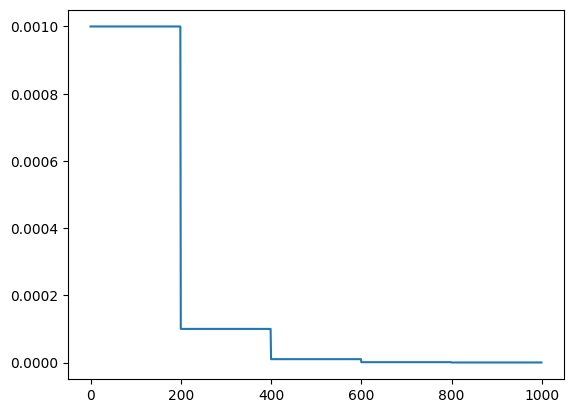

In [96]:
plt.plot([i for i in range(len(history["lr"]))], history["lr"])

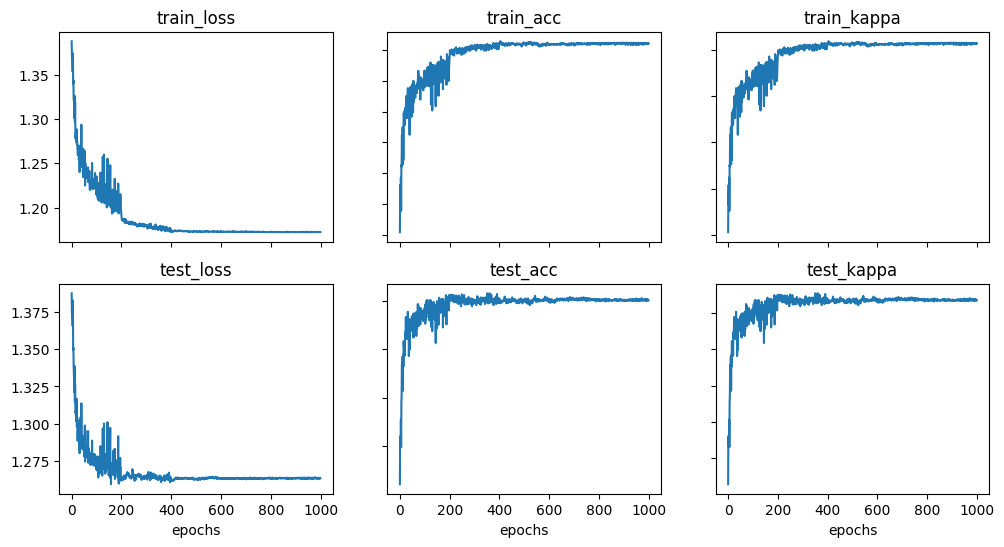

In [97]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

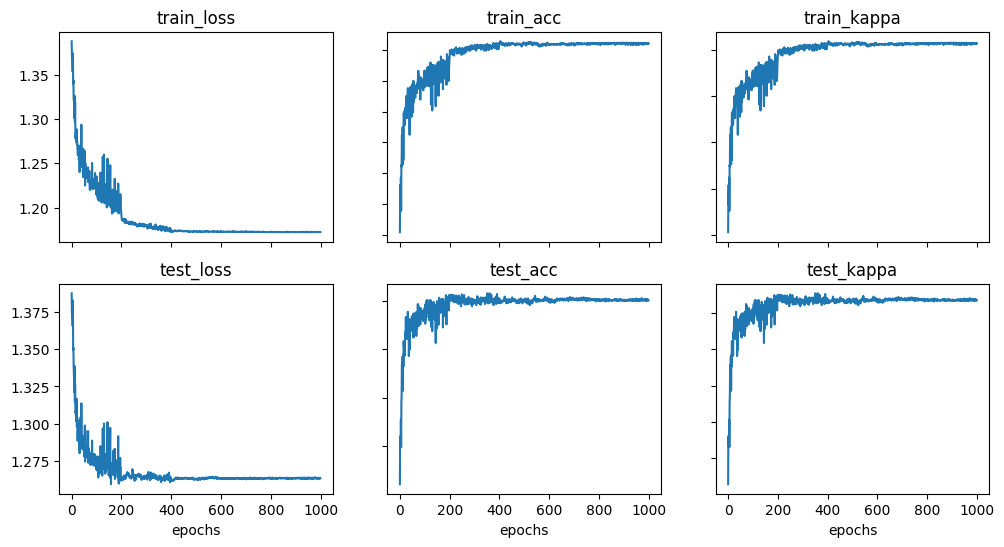

In [98]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()